<a href="https://colab.research.google.com/github/limited-fion/deep-learning-cw/blob/master/03_cw.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Only modify the given CNN architecture to **add Dropout or Batch Normalization ** layers when explicitly stated. Use **40 epochs** to plot all of your curves. However, you can **train for more epochs to find your best validation performance if your network has not finished training in those 40 epochs.**

In [37]:
import numpy as np
import keras
from keras.layers import Conv2D, MaxPooling2D, GlobalAveragePooling2D
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, BatchNormalization
from keras.utils import np_utils
from keras.datasets import cifar10
from keras.optimizers import Adam, SGD
from keras import regularizers
import matplotlib.pyplot as plt
from tensorflow.keras.layers.experimental import preprocessing
from google.colab import drive
from keras.models import load_model
import os
drive.mount('/content/drive')

def plot_history(history, fileName, metric = None):
  # Plots the loss history of training and validation (if existing)
  # and a given metric
  # Be careful because the axis ranges are automatically adapted
  # which may not desirable to compare different runs.
  # Also, in some cases you may want to combine several curves in one
  # figure for easier comparison, which this function does not do.

  if metric != None:
    fig, axes = plt.subplots(2,1, figsize=(15,10))
    axes[0].plot(history.history[metric])
    try:
      axes[0].plot(history.history['val_'+metric])
      axes[0].legend(['Training', 'Validation'], fontsize=14)
      axes[0].tick_params(axis='x', which='major', labelsize=12)
      axes[0].tick_params(axis='y', which='major', labelsize=12)
    except:
      pass
    axes[0].set_title('Validation Accuracy', fontsize = 18)
    axes[0].set_ylabel('Accuracy', fontsize = 14)
    axes[0].set_xlabel('Epoch', fontsize = 14)
    fig.subplots_adjust(hspace=0.5)
    axes[1].plot(history.history['loss'])
    try:
      axes[1].plot(history.history['val_loss'])
      axes[1].legend(['Training', 'Validation'], fontsize=14)
      axes[1].tick_params(axis='x', which='major', labelsize=12)
      axes[1].tick_params(axis='y', which='major', labelsize=12)
    except:
      pass
    axes[1].set_title('Model Loss', fontsize = 18)
    axes[1].set_ylabel('Loss', fontsize = 14)
    axes[1].set_xlabel('Epoch', fontsize = 14)
  else:
    plt.plot(history.history['loss'])
    try:
      plt.plot(history.history['val_loss'])
      plt.legend(['Training', 'Validation'], fontsize=14)
    except:
      pass
    plt.title('Model Loss', fontsize = 18)
    plt.yticks(fontsize = 12)
    plt.xticks(fontsize = 12)
    plt.ylabel('Loss', fontsize = 14)
    plt.xlabel('Epoch', fontsize = 14)

  directory = '/content/drive/MyDrive/dl-cw-03/diagrams/'
  
  if not os.path.exists(directory):
    os.makedirs(directory)

  plt.savefig(os.path.join(directory, fileName))

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [32]:
import matplotlib as mpl
import matplotlib.font_manager as fm
from matplotlib import font_manager as fm

!wget https://github.com/trishume/OpenTuringCompiler/blob/master/stdlib-sfml/fonts/Times%20New%20Roman.ttf

font_files = fm.findSystemFonts()

# Go through and add each to Matplotlib's font cache.
for font_file in font_files:
    fm.fontManager.addfont(font_file)

# fm.fontManager.ttflist += fm.createFontList(['Times New Roman.ttf'])

# Use your new font on all your plots.
plt.rc('font', family='serif')

--2023-02-28 00:55:49--  https://github.com/trishume/OpenTuringCompiler/blob/master/stdlib-sfml/fonts/Times%20New%20Roman.ttf
Resolving github.com (github.com)... 140.82.113.4
Connecting to github.com (github.com)|140.82.113.4|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: unspecified [text/html]
Saving to: ‘Times New Roman.ttf’

Times New Roman.ttf     [ <=>                ] 141.65K  --.-KB/s    in 0.07s   

2023-02-28 00:55:50 (1.92 MB/s) - ‘Times New Roman.ttf’ saved [145052]



# **Data augmentation 1: Default model without any data augmentation**

In [48]:
# load the data
(X_train, y_train), (X_test, y_test) = cifar10.load_data()

print('Image shape: {0}'.format(X_train.shape[1:]))
print('Total number of training samples: {0}'.format(X_train.shape[0]))
print('Total number of validation samples: {0}'.format(X_test.shape[0]))

X_train = X_train.reshape(-1,32,32,3)

## Normalization block
norm_layer = preprocessing.Normalization()
norm_layer.adapt(X_train)
X_train_n = norm_layer(X_train)
X_test_n = norm_layer(X_test)

# You can modify the data_augmentation variable below to add your
# data augmentation pipeline.
# By default we do not apply any augmentation (RandomZoom(0) is equivalent
# to not performing any augmentation)
data_augmentation = keras.Sequential(
    [
        preprocessing.RandomZoom(0)
    ]
)
# We will use glorot_uniform as a initialization by default
initialization = 'glorot_uniform'
# Use the architecture given below, only modify it to add Dropout/BatchNorm
model = Sequential()
model.add(data_augmentation)
model.add(Conv2D(32, (3, 3), padding='same', kernel_initializer=initialization))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2), padding='same'))

model.add(Conv2D(64, (3, 3), padding='same', kernel_initializer=initialization))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2), padding='same'))

model.add(Conv2D(128, (3, 3), padding='same', kernel_initializer=initialization))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2), padding='same'))

model.add(Conv2D(256, (3, 3), padding='same', kernel_initializer=initialization))
model.add(Activation('relu'))
# As we use global average pooling, we don't need to use Flatten
model.add(GlobalAveragePooling2D())
model.add(Dense(10, kernel_initializer=initialization))
model.add(Activation('softmax'))


Y_train_class = np_utils.to_categorical(y_train, 10)
Y_test_class = np_utils.to_categorical(y_test, 10)
# By default use Adam with lr=3e-4. Change it to SGD when asked to
opt = Adam(lr=3e-4)
model.compile(loss='categorical_crossentropy',
              optimizer=opt,
              metrics=['accuracy'])
# Use 40 epochs as default value to plot your curves
history_da1 = model.fit(X_train_n, Y_train_class, epochs=40, validation_data=(X_test_n,Y_test_class))

model.save('/content/drive/MyDrive/dl-cw-03/dataAug/da1')

Image shape: (32, 32, 3)
Total number of training samples: 50000
Total number of validation samples: 10000
Epoch 1/40


/usr/local/lib/python3.8/dist-packages/keras/optimizers/optimizer_v2/adam.py:117: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


1563/1563 [==============================] - 29s 17ms/step - loss: 1.5540 - accuracy: 0.4320 - val_loss: 1.2960 - val_accuracy: 0.5272
Epoch 2/40
1563/1563 [==============================] - 26s 17ms/step - loss: 1.1950 - accuracy: 0.5716 - val_loss: 1.1722 - val_accuracy: 0.5795
Epoch 3/40
1563/1563 [==============================] - 27s 17ms/step - loss: 1.0337 - accuracy: 0.6344 - val_loss: 1.0348 - val_accuracy: 0.6277
Epoch 4/40
1563/1563 [==============================] - 26s 17ms/step - loss: 0.9228 - accuracy: 0.6745 - val_loss: 0.9414 - val_accuracy: 0.6586
Epoch 5/40
1563/1563 [==============================] - 26s 17ms/step - loss: 0.8321 - accuracy: 0.7060 - val_loss: 0.8468 - val_accuracy: 0.7022
Epoch 6/40
1563/1563 [==============================] - 26s 17ms/step - loss: 0.7622 - accuracy: 0.7329 - val_loss: 0.7977 - val_accuracy: 0.7174
Epoch 7/40
1563/1563 [==============================] - 26s 17ms/step - loss: 0.6998 - accuracy: 0.7578 - val_loss: 0.7527 - val_accura

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_4 (Sequential)   (None, 32, 32, 3)         0         
                                                                 
 conv2d_8 (Conv2D)           (None, 32, 32, 32)        896       
                                                                 
 activation_10 (Activation)  (None, 32, 32, 32)        0         
                                                                 
 max_pooling2d_6 (MaxPooling  (None, 16, 16, 32)       0         
 2D)                                                             
                                                                 
 conv2d_9 (Conv2D)           (None, 16, 16, 64)        18496     
                                                                 
 activation_11 (Activation)  (None, 16, 16, 64)        0         
                                                      

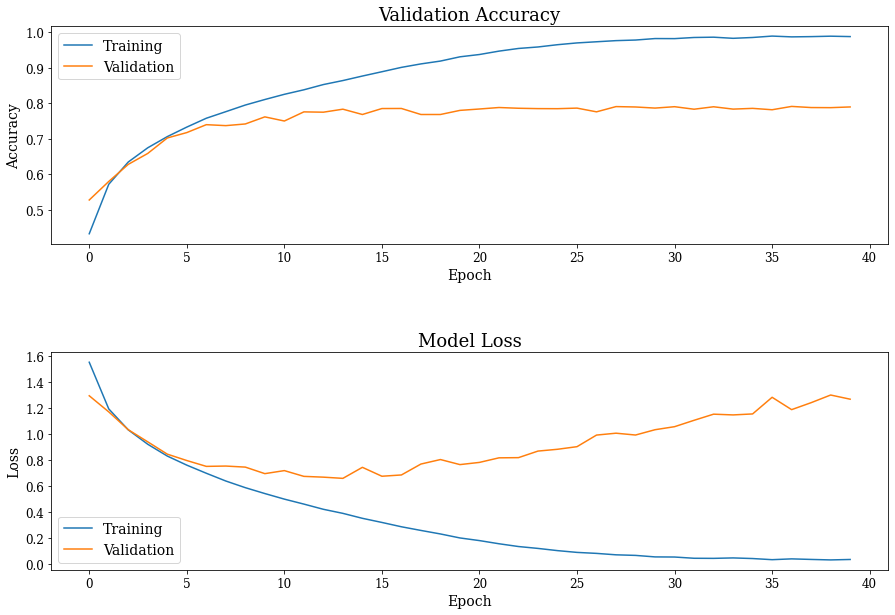

In [52]:
plot_history(history_da1, 'da1.png', metric='accuracy')
model.summary()

*   Define two data augmentation strategies (one more aggressive than the other) and train the model with data augmentation. Clearly state the two augmentation strategies you apply (i.e., the specific transformations). Discuss the training and validation loss curves for the two data augmentation strategies along with the original run without data augmentation. 



# **Data augmentation 2 - Flip vertical; Rotation: 0.1**

In [14]:
# load the data
(X_train, y_train), (X_test, y_test) = cifar10.load_data()

print('Image shape: {0}'.format(X_train.shape[1:]))
print('Total number of training samples: {0}'.format(X_train.shape[0]))
print('Total number of validation samples: {0}'.format(X_test.shape[0]))

X_train = X_train.reshape(-1,32,32,3)

## Normalization block
norm_layer = preprocessing.Normalization()
norm_layer.adapt(X_train)
X_train_n = norm_layer(X_train)
X_test_n = norm_layer(X_test)

data_augmentation = keras.Sequential(
    [   
        preprocessing.RandomFlip("vertical"),
        preprocessing.RandomRotation(0.1)
    ]
)

Image shape: (32, 32, 3)
Total number of training samples: 50000
Total number of validation samples: 10000


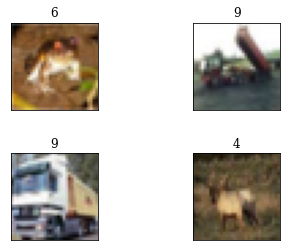

In [50]:
N=2
# fig1 = plt.figure(figsize=(10,10))
# fig1 = plt.imshow(X_train[0], cmap='gray')
start_val = 0 # pick an element for the code to plot the following N**2 values
fig, axes = plt.subplots(N,N)
items = list(range(0, 10))
for row in range(N):
  for col in range(N):
    idx = start_val+row+N*col
    axes[row,col].imshow(X_train[idx], cmap='gray')
    fig.subplots_adjust(hspace=0.5)
    y_target = int(y_train[idx])
    target = str(items[y_target])
    axes[row,col].set_title(target)
    axes[row,col].set_xticks([])
    axes[row,col].set_yticks([])
     

In [15]:
# We will use glorot_uniform as a initialization by default
initialization = 'glorot_uniform'
# Use the architecture given below, only modify it to add Dropout/BatchNorm
model = Sequential()
model.add(data_augmentation)
model.add(Conv2D(32, (3, 3), padding='same', kernel_initializer=initialization))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2), padding='same'))

model.add(Conv2D(64, (3, 3), padding='same', kernel_initializer=initialization))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2), padding='same'))

model.add(Conv2D(128, (3, 3), padding='same', kernel_initializer=initialization))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2), padding='same'))

model.add(Conv2D(256, (3, 3), padding='same', kernel_initializer=initialization))
model.add(Activation('relu'))
# As we use global average pooling, we don't need to use Flatten
model.add(GlobalAveragePooling2D())
model.add(Dense(10, kernel_initializer=initialization))
model.add(Activation('softmax'))


Y_train_class = np_utils.to_categorical(y_train, 10)
Y_test_class = np_utils.to_categorical(y_test, 10)
# By default use Adam with lr=3e-4. Change it to SGD when asked to
opt = Adam(lr=3e-4)
model.compile(loss='categorical_crossentropy',
              optimizer=opt,
              metrics=['accuracy'])
# Use 40 epochs as default value to plot your curves
history_da2 = model.fit(X_train_n, Y_train_class, epochs=40, validation_data=(X_test_n,Y_test_class))

model.save('/content/drive/MyDrive/dl-cw-03/dataAug/da2')

Epoch 1/40


/usr/local/lib/python3.8/dist-packages/keras/optimizers/optimizer_v2/adam.py:117: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


1563/1563 [==============================] - 36s 21ms/step - loss: 1.6458 - accuracy: 0.3984 - val_loss: 1.4119 - val_accuracy: 0.4947
Epoch 2/40
1563/1563 [==============================] - 33s 21ms/step - loss: 1.3308 - accuracy: 0.5212 - val_loss: 1.2460 - val_accuracy: 0.5643
Epoch 3/40
1563/1563 [==============================] - 33s 21ms/step - loss: 1.2013 - accuracy: 0.5703 - val_loss: 1.0837 - val_accuracy: 0.6233
Epoch 4/40
1563/1563 [==============================] - 33s 21ms/step - loss: 1.1103 - accuracy: 0.6089 - val_loss: 1.0747 - val_accuracy: 0.6263
Epoch 5/40
1563/1563 [==============================] - 33s 21ms/step - loss: 1.0351 - accuracy: 0.6349 - val_loss: 0.9640 - val_accuracy: 0.6579
Epoch 6/40
1563/1563 [==============================] - 33s 21ms/step - loss: 0.9748 - accuracy: 0.6558 - val_loss: 0.9394 - val_accuracy: 0.6750
Epoch 7/40
1563/1563 [==============================] - 33s 21ms/step - loss: 0.9227 - accuracy: 0.6750 - val_loss: 0.8527 - val_accura

Model: "sequential_35"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_34 (Sequential)  (None, 32, 32, 3)         0         
                                                                 
 conv2d_68 (Conv2D)          (None, 32, 32, 32)        896       
                                                                 
 activation_85 (Activation)  (None, 32, 32, 32)        0         
                                                                 
 max_pooling2d_51 (MaxPoolin  (None, 16, 16, 32)       0         
 g2D)                                                            
                                                                 
 conv2d_69 (Conv2D)          (None, 16, 16, 64)        18496     
                                                                 
 activation_86 (Activation)  (None, 16, 16, 64)        0         
                                                     

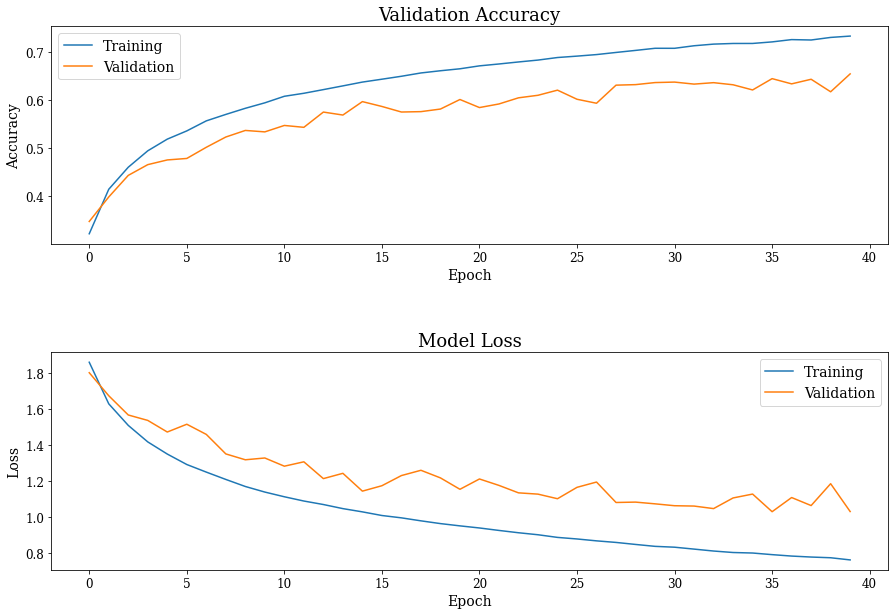

In [34]:
plot_history(history_da2, 'da2.png', metric='accuracy')
model.summary()

# **Data augmentation 3 - Flip vertical; Rotation: 0.8**

In [31]:
# load the data
(X_train, y_train), (X_test, y_test) = cifar10.load_data()

print('Image shape: {0}'.format(X_train.shape[1:]))
print('Total number of training samples: {0}'.format(X_train.shape[0]))
print('Total number of validation samples: {0}'.format(X_test.shape[0]))

X_train = X_train.reshape(-1,32,32,3)

## Normalization block
norm_layer = preprocessing.Normalization()
norm_layer.adapt(X_train)
X_train_n = norm_layer(X_train)
X_test_n = norm_layer(X_test)

data_augmentation = keras.Sequential(
    [   
        preprocessing.RandomFlip("vertical"),
        preprocessing.RandomRotation(0.8)
    ]
)

# We will use glorot_uniform as a initialization by default
initialization = 'glorot_uniform'
# Use the architecture given below, only modify it to add Dropout/BatchNorm
model = Sequential()
model.add(data_augmentation)
model.add(Conv2D(32, (3, 3), padding='same', kernel_initializer=initialization))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2), padding='same'))

model.add(Conv2D(64, (3, 3), padding='same', kernel_initializer=initialization))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2), padding='same'))

model.add(Conv2D(128, (3, 3), padding='same', kernel_initializer=initialization))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2), padding='same'))

model.add(Conv2D(256, (3, 3), padding='same', kernel_initializer=initialization))
model.add(Activation('relu'))
# As we use global average pooling, we don't need to use Flatten
model.add(GlobalAveragePooling2D())
model.add(Dense(10, kernel_initializer=initialization))
model.add(Activation('softmax'))


Y_train_class = np_utils.to_categorical(y_train, 10)
Y_test_class = np_utils.to_categorical(y_test, 10)
# By default use Adam with lr=3e-4. Change it to SGD when asked to
opt = Adam(lr=3e-4)
model.compile(loss='categorical_crossentropy',
              optimizer=opt,
              metrics=['accuracy'])
# Use 40 epochs as default value to plot your curves
history_da2_2 = model.fit(X_train_n, Y_train_class, epochs=70, validation_data=(X_test_n,Y_test_class))

model.save('/content/drive/MyDrive/dl-cw-03/dataAug/da2-2')

Image shape: (32, 32, 3)
Total number of training samples: 50000
Total number of validation samples: 10000
Epoch 1/70


/usr/local/lib/python3.8/dist-packages/keras/optimizers/optimizer_v2/adam.py:117: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


1563/1563 [==============================] - 32s 19ms/step - loss: 1.8666 - accuracy: 0.3121 - val_loss: 1.7286 - val_accuracy: 0.3623
Epoch 2/70
1563/1563 [==============================] - 29s 19ms/step - loss: 1.6252 - accuracy: 0.4142 - val_loss: 1.4870 - val_accuracy: 0.4706
Epoch 3/70
1563/1563 [==============================] - 29s 19ms/step - loss: 1.5028 - accuracy: 0.4600 - val_loss: 1.4222 - val_accuracy: 0.4980
Epoch 4/70
1563/1563 [==============================] - 29s 18ms/step - loss: 1.4257 - accuracy: 0.4871 - val_loss: 1.4103 - val_accuracy: 0.4986
Epoch 5/70
1563/1563 [==============================] - 29s 18ms/step - loss: 1.3590 - accuracy: 0.5160 - val_loss: 1.3864 - val_accuracy: 0.5063
Epoch 6/70
1563/1563 [==============================] - 29s 18ms/step - loss: 1.2992 - accuracy: 0.5341 - val_loss: 1.3059 - val_accuracy: 0.5367
Epoch 7/70
1563/1563 [==============================] - 29s 19ms/step - loss: 1.2505 - accuracy: 0.5529 - val_loss: 1.2478 - val_accura

Model: "sequential_35"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_34 (Sequential)  (None, 32, 32, 3)         0         
                                                                 
 conv2d_68 (Conv2D)          (None, 32, 32, 32)        896       
                                                                 
 activation_85 (Activation)  (None, 32, 32, 32)        0         
                                                                 
 max_pooling2d_51 (MaxPoolin  (None, 16, 16, 32)       0         
 g2D)                                                            
                                                                 
 conv2d_69 (Conv2D)          (None, 16, 16, 64)        18496     
                                                                 
 activation_86 (Activation)  (None, 16, 16, 64)        0         
                                                     

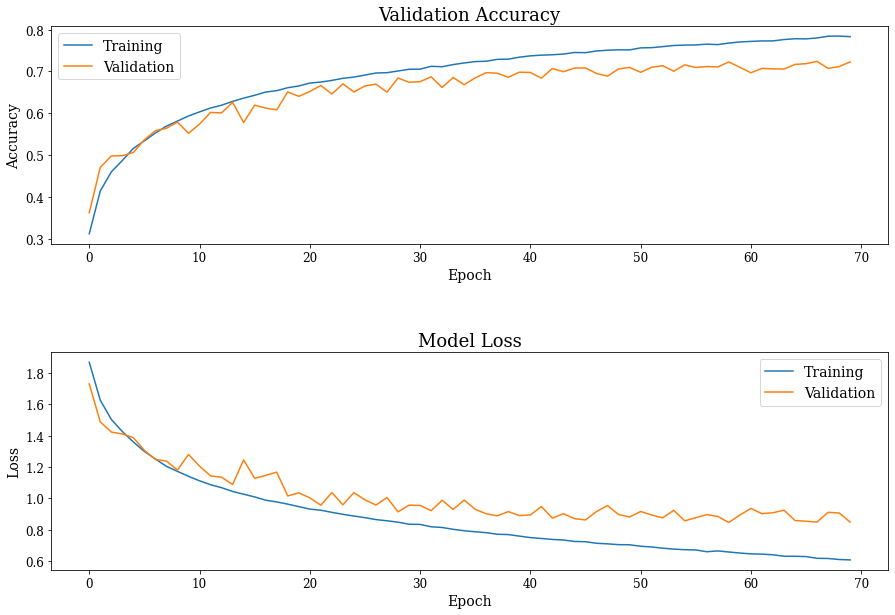

In [33]:
plot_history(history_da2_2, 'da2-2.png', metric='accuracy')
model.summary()

# **Data augmentation 8 - Flip horizontal; Rotation: 0.2**


In [36]:
# load the data
(X_train, y_train), (X_test, y_test) = cifar10.load_data()

print('Image shape: {0}'.format(X_train.shape[1:]))
print('Total number of training samples: {0}'.format(X_train.shape[0]))
print('Total number of validation samples: {0}'.format(X_test.shape[0]))

X_train = X_train.reshape(-1,32,32,3)

## Normalization block
norm_layer = preprocessing.Normalization()
norm_layer.adapt(X_train)
X_train_n = norm_layer(X_train)
X_test_n = norm_layer(X_test)

data_augmentation = keras.Sequential(
    [   
        preprocessing.RandomFlip("horizontal"),
        preprocessing.RandomZoom(0.2)
    ]
)

# We will use glorot_uniform as a initialization by default
initialization = 'glorot_uniform'
# Use the architecture given below, only modify it to add Dropout/BatchNorm
model = Sequential()
model.add(data_augmentation)
model.add(Conv2D(32, (3, 3), padding='same', kernel_initializer=initialization))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2), padding='same'))

model.add(Conv2D(64, (3, 3), padding='same', kernel_initializer=initialization))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2), padding='same'))

model.add(Conv2D(128, (3, 3), padding='same', kernel_initializer=initialization))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2), padding='same'))

model.add(Conv2D(256, (3, 3), padding='same', kernel_initializer=initialization))
model.add(Activation('relu'))
# As we use global average pooling, we don't need to use Flatten
model.add(GlobalAveragePooling2D())
model.add(Dense(10, kernel_initializer=initialization))
model.add(Activation('softmax'))


Y_train_class = np_utils.to_categorical(y_train, 10)
Y_test_class = np_utils.to_categorical(y_test, 10)
# By default use Adam with lr=3e-4. Change it to SGD when asked to
opt = Adam(lr=3e-4)
model.compile(loss='categorical_crossentropy',
              optimizer=opt,
              metrics=['accuracy'])
# Use 40 epochs as default value to plot your curves
history_da8 = model.fit(X_train_n, Y_train_class, epochs=40, validation_data=(X_test_n,Y_test_class))

model.save('/content/drive/MyDrive/dl-cw-03/dataAug/da8')

Image shape: (32, 32, 3)
Total number of training samples: 50000
Total number of validation samples: 10000
Epoch 1/40


/usr/local/lib/python3.8/dist-packages/keras/optimizers/optimizer_v2/adam.py:117: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


1563/1563 [==============================] - 33s 19ms/step - loss: 1.5903 - accuracy: 0.4195 - val_loss: 1.3493 - val_accuracy: 0.5118
Epoch 2/40
1563/1563 [==============================] - 30s 19ms/step - loss: 1.2579 - accuracy: 0.5491 - val_loss: 1.1789 - val_accuracy: 0.5816
Epoch 3/40
1563/1563 [==============================] - 29s 19ms/step - loss: 1.1048 - accuracy: 0.6089 - val_loss: 1.0433 - val_accuracy: 0.6290
Epoch 4/40
1563/1563 [==============================] - 29s 19ms/step - loss: 1.0039 - accuracy: 0.6464 - val_loss: 0.9527 - val_accuracy: 0.6661
Epoch 5/40
1563/1563 [==============================] - 29s 19ms/step - loss: 0.9148 - accuracy: 0.6799 - val_loss: 0.8513 - val_accuracy: 0.6991
Epoch 6/40
1563/1563 [==============================] - 29s 19ms/step - loss: 0.8493 - accuracy: 0.7021 - val_loss: 0.8178 - val_accuracy: 0.7178
Epoch 7/40
1563/1563 [==============================] - 29s 19ms/step - loss: 0.7858 - accuracy: 0.7252 - val_loss: 0.7824 - val_accura

Model: "sequential_37"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_36 (Sequential)  (None, 32, 32, 3)         0         
                                                                 
 conv2d_72 (Conv2D)          (None, 32, 32, 32)        896       
                                                                 
 activation_90 (Activation)  (None, 32, 32, 32)        0         
                                                                 
 max_pooling2d_54 (MaxPoolin  (None, 16, 16, 32)       0         
 g2D)                                                            
                                                                 
 conv2d_73 (Conv2D)          (None, 16, 16, 64)        18496     
                                                                 
 activation_91 (Activation)  (None, 16, 16, 64)        0         
                                                     

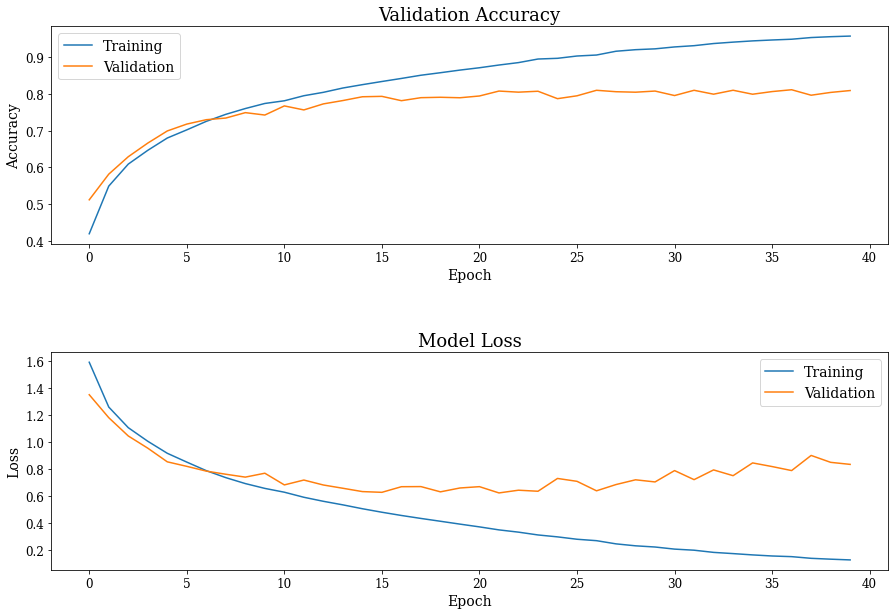

In [38]:
plot_history(history_da8, 'da8.png', metric='accuracy')
model.summary()

# **Data augmentation 9 - Flip horizontal; Rotation: 0.7**


In [39]:
# load the data
(X_train, y_train), (X_test, y_test) = cifar10.load_data()

print('Image shape: {0}'.format(X_train.shape[1:]))
print('Total number of training samples: {0}'.format(X_train.shape[0]))
print('Total number of validation samples: {0}'.format(X_test.shape[0]))

X_train = X_train.reshape(-1,32,32,3)

## Normalization block
norm_layer = preprocessing.Normalization()
norm_layer.adapt(X_train)
X_train_n = norm_layer(X_train)
X_test_n = norm_layer(X_test)

data_augmentation = keras.Sequential(
    [   
        preprocessing.RandomFlip("horizontal"),
        preprocessing.RandomZoom(0.7)
    ]
)

# We will use glorot_uniform as a initialization by default
initialization = 'glorot_uniform'
# Use the architecture given below, only modify it to add Dropout/BatchNorm
model = Sequential()
model.add(data_augmentation)
model.add(Conv2D(32, (3, 3), padding='same', kernel_initializer=initialization))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2), padding='same'))

model.add(Conv2D(64, (3, 3), padding='same', kernel_initializer=initialization))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2), padding='same'))

model.add(Conv2D(128, (3, 3), padding='same', kernel_initializer=initialization))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2), padding='same'))

model.add(Conv2D(256, (3, 3), padding='same', kernel_initializer=initialization))
model.add(Activation('relu'))
# As we use global average pooling, we don't need to use Flatten
model.add(GlobalAveragePooling2D())
model.add(Dense(10, kernel_initializer=initialization))
model.add(Activation('softmax'))


Y_train_class = np_utils.to_categorical(y_train, 10)
Y_test_class = np_utils.to_categorical(y_test, 10)
# By default use Adam with lr=3e-4. Change it to SGD when asked to
opt = Adam(lr=3e-4)
model.compile(loss='categorical_crossentropy',
              optimizer=opt,
              metrics=['accuracy'])
# Use 40 epochs as default value to plot your curves
history_da9 = model.fit(X_train_n, Y_train_class, epochs=40, validation_data=(X_test_n,Y_test_class))

model.save('/content/drive/MyDrive/dl-cw-03/dataAug/da9')

Image shape: (32, 32, 3)
Total number of training samples: 50000
Total number of validation samples: 10000
Epoch 1/40


/usr/local/lib/python3.8/dist-packages/keras/optimizers/optimizer_v2/adam.py:117: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


1563/1563 [==============================] - 32s 19ms/step - loss: 1.7472 - accuracy: 0.3557 - val_loss: 1.4735 - val_accuracy: 0.4493
Epoch 2/40
1563/1563 [==============================] - 29s 19ms/step - loss: 1.4731 - accuracy: 0.4702 - val_loss: 1.2512 - val_accuracy: 0.5493
Epoch 3/40
1563/1563 [==============================] - 29s 19ms/step - loss: 1.3382 - accuracy: 0.5231 - val_loss: 1.1006 - val_accuracy: 0.6127
Epoch 4/40
1563/1563 [==============================] - 29s 19ms/step - loss: 1.2399 - accuracy: 0.5597 - val_loss: 1.0389 - val_accuracy: 0.6269
Epoch 5/40
1563/1563 [==============================] - 29s 19ms/step - loss: 1.1645 - accuracy: 0.5868 - val_loss: 1.0092 - val_accuracy: 0.6408
Epoch 6/40
1563/1563 [==============================] - 29s 19ms/step - loss: 1.1081 - accuracy: 0.6118 - val_loss: 0.9512 - val_accuracy: 0.6613
Epoch 7/40
1563/1563 [==============================] - 29s 19ms/step - loss: 1.0511 - accuracy: 0.6308 - val_loss: 0.8773 - val_accura

Model: "sequential_39"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_38 (Sequential)  (None, 32, 32, 3)         0         
                                                                 
 conv2d_76 (Conv2D)          (None, 32, 32, 32)        896       
                                                                 
 activation_95 (Activation)  (None, 32, 32, 32)        0         
                                                                 
 max_pooling2d_57 (MaxPoolin  (None, 16, 16, 32)       0         
 g2D)                                                            
                                                                 
 conv2d_77 (Conv2D)          (None, 16, 16, 64)        18496     
                                                                 
 activation_96 (Activation)  (None, 16, 16, 64)        0         
                                                     

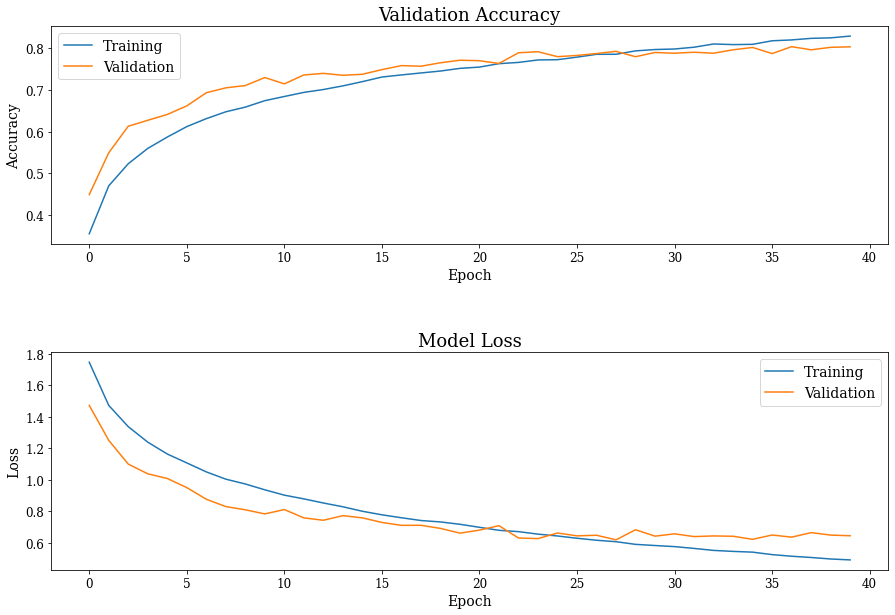

In [40]:
plot_history(history_da9, 'da9.png', metric='accuracy')
model.summary()

In [41]:
# load the data
(X_train, y_train), (X_test, y_test) = cifar10.load_data()

print('Image shape: {0}'.format(X_train.shape[1:]))
print('Total number of training samples: {0}'.format(X_train.shape[0]))
print('Total number of validation samples: {0}'.format(X_test.shape[0]))

X_train = X_train.reshape(-1,32,32,3)

## Normalization block
norm_layer = preprocessing.Normalization()
norm_layer.adapt(X_train)
X_train_n = norm_layer(X_train)
X_test_n = norm_layer(X_test)

data_augmentation = keras.Sequential(
    [   
        preprocessing.RandomFlip("horizontal"),
        preprocessing.RandomZoom(0.9)
    ]
)

# We will use glorot_uniform as a initialization by default
initialization = 'glorot_uniform'
# Use the architecture given below, only modify it to add Dropout/BatchNorm
model = Sequential()
model.add(data_augmentation)
model.add(Conv2D(32, (3, 3), padding='same', kernel_initializer=initialization))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2), padding='same'))

model.add(Conv2D(64, (3, 3), padding='same', kernel_initializer=initialization))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2), padding='same'))

model.add(Conv2D(128, (3, 3), padding='same', kernel_initializer=initialization))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2), padding='same'))

model.add(Conv2D(256, (3, 3), padding='same', kernel_initializer=initialization))
model.add(Activation('relu'))
# As we use global average pooling, we don't need to use Flatten
model.add(GlobalAveragePooling2D())
model.add(Dense(10, kernel_initializer=initialization))
model.add(Activation('softmax'))


Y_train_class = np_utils.to_categorical(y_train, 10)
Y_test_class = np_utils.to_categorical(y_test, 10)
# By default use Adam with lr=3e-4. Change it to SGD when asked to
opt = Adam(lr=3e-4)
model.compile(loss='categorical_crossentropy',
              optimizer=opt,
              metrics=['accuracy'])
# Use 40 epochs as default value to plot your curves
history_da10 = model.fit(X_train_n, Y_train_class, epochs=40, validation_data=(X_test_n,Y_test_class))

model.save('/content/drive/MyDrive/dl-cw-03/dataAug/da10')

Image shape: (32, 32, 3)
Total number of training samples: 50000
Total number of validation samples: 10000
Epoch 1/40


/usr/local/lib/python3.8/dist-packages/keras/optimizers/optimizer_v2/adam.py:117: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


1563/1563 [==============================] - 32s 19ms/step - loss: 1.8114 - accuracy: 0.3285 - val_loss: 1.5502 - val_accuracy: 0.4333
Epoch 2/40
1563/1563 [==============================] - 28s 18ms/step - loss: 1.5683 - accuracy: 0.4314 - val_loss: 1.2952 - val_accuracy: 0.5378
Epoch 3/40
1563/1563 [==============================] - 28s 18ms/step - loss: 1.4365 - accuracy: 0.4815 - val_loss: 1.1679 - val_accuracy: 0.5815
Epoch 4/40
1563/1563 [==============================] - 29s 18ms/step - loss: 1.3468 - accuracy: 0.5170 - val_loss: 1.0679 - val_accuracy: 0.6202
Epoch 5/40
1563/1563 [==============================] - 28s 18ms/step - loss: 1.2749 - accuracy: 0.5424 - val_loss: 1.0051 - val_accuracy: 0.6409
Epoch 6/40
1563/1563 [==============================] - 28s 18ms/step - loss: 1.2208 - accuracy: 0.5650 - val_loss: 0.9777 - val_accuracy: 0.6505
Epoch 7/40
1563/1563 [==============================] - 28s 18ms/step - loss: 1.1702 - accuracy: 0.5845 - val_loss: 0.9672 - val_accura

In [ ]:
plot_history(history_da10, 'da10.png', metric='accuracy')
model.summary()

In [ ]:
# load the data
(X_train, y_train), (X_test, y_test) = cifar10.load_data()

print('Image shape: {0}'.format(X_train.shape[1:]))
print('Total number of training samples: {0}'.format(X_train.shape[0]))
print('Total number of validation samples: {0}'.format(X_test.shape[0]))

X_train = X_train.reshape(-1,32,32,3)

## Normalization block
norm_layer = preprocessing.Normalization()
norm_layer.adapt(X_train)
X_train_n = norm_layer(X_train)
X_test_n = norm_layer(X_test)

data_augmentation = keras.Sequential(
    [   
        preprocessing.RandomFlip("horizontal"),
        preprocessing.RandomZoom(0.5)
    ]
)

# We will use glorot_uniform as a initialization by default
initialization = 'glorot_uniform'
# Use the architecture given below, only modify it to add Dropout/BatchNorm
model = Sequential()
model.add(data_augmentation)
model.add(Conv2D(32, (3, 3), padding='same', kernel_initializer=initialization))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2), padding='same'))

model.add(Conv2D(64, (3, 3), padding='same', kernel_initializer=initialization))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2), padding='same'))

model.add(Conv2D(128, (3, 3), padding='same', kernel_initializer=initialization))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2), padding='same'))

model.add(Conv2D(256, (3, 3), padding='same', kernel_initializer=initialization))
model.add(Activation('relu'))
# As we use global average pooling, we don't need to use Flatten
model.add(GlobalAveragePooling2D())
model.add(Dense(10, kernel_initializer=initialization))
model.add(Activation('softmax'))


Y_train_class = np_utils.to_categorical(y_train, 10)
Y_test_class = np_utils.to_categorical(y_test, 10)
# By default use Adam with lr=3e-4. Change it to SGD when asked to
opt = Adam(lr=3e-4)
model.compile(loss='categorical_crossentropy',
              optimizer=opt,
              metrics=['accuracy'])
# Use 40 epochs as default value to plot your curves
history_da11 = model.fit(X_train_n, Y_train_class, epochs=40, validation_data=(X_test_n,Y_test_class))

model.save('/content/drive/MyDrive/dl-cw-03/dataAug/da11')

In [ ]:
plot_history(history_da11, 'da11.png', metric='accuracy')
model.summary()

# **Data augmentation 4 - Rotation: 0.1; Zoom: Height: 0.1** 

ok but accuracy not high enough


In [27]:
# load the data
(X_train, y_train), (X_test, y_test) = cifar10.load_data()

print('Image shape: {0}'.format(X_train.shape[1:]))
print('Total number of training samples: {0}'.format(X_train.shape[0]))
print('Total number of validation samples: {0}'.format(X_test.shape[0]))

X_train = X_train.reshape(-1,32,32,3)

## Normalization block
norm_layer = preprocessing.Normalization()
norm_layer.adapt(X_train)
X_train_n = norm_layer(X_train)
X_test_n = norm_layer(X_test)

# You can modify the data_augmentation variable below to add your
# data augmentation pipeline.
# By default we do not apply any augmentation (RandomZoom(0) is equivalent
# to not performing any augmentation)
data_augmentation = keras.Sequential(
    [   
        preprocessing.RandomRotation(0.1),
        preprocessing.RandomZoom(height_factor=0.1),
    ]
)
# We will use glorot_uniform as a initialization by default
initialization = 'glorot_uniform'
# Use the architecture given below, only modify it to add Dropout/BatchNorm
model = Sequential()
model.add(data_augmentation)
model.add(Conv2D(32, (3, 3), padding='same', kernel_initializer=initialization))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2), padding='same'))

model.add(Conv2D(64, (3, 3), padding='same', kernel_initializer=initialization))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2), padding='same'))

model.add(Conv2D(128, (3, 3), padding='same', kernel_initializer=initialization))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2), padding='same'))

model.add(Conv2D(256, (3, 3), padding='same', kernel_initializer=initialization))
model.add(Activation('relu'))
# As we use global average pooling, we don't need to use Flatten
model.add(GlobalAveragePooling2D())
model.add(Dense(10, kernel_initializer=initialization))
model.add(Activation('softmax'))


Y_train_class = np_utils.to_categorical(y_train, 10)
Y_test_class = np_utils.to_categorical(y_test, 10)
# By default use Adam with lr=3e-4. Change it to SGD when asked to
opt = Adam(lr=3e-4)
model.compile(loss='categorical_crossentropy',
              optimizer=opt,
              metrics=['accuracy'])
# Use 40 epochs as default value to plot your curves
history_da4 = model.fit(X_train_n, Y_train_class, epochs=40, validation_data=(X_test_n,Y_test_class))

model.save('/content/drive/MyDrive/dl-cw-03/dataAug/da4')

Image shape: (32, 32, 3)
Total number of training samples: 50000
Total number of validation samples: 10000
Epoch 1/40


1563/1563 [==============================] - 41s 22ms/step - loss: 1.6646 - accuracy: 0.3925 - val_loss: 1.4088 - val_accuracy: 0.4841
Epoch 2/40
1563/1563 [==============================] - 34s 21ms/step - loss: 1.3793 - accuracy: 0.5071 - val_loss: 1.2250 - val_accuracy: 0.5572
Epoch 3/40
1563/1563 [==============================] - 34s 22ms/step - loss: 1.2514 - accuracy: 0.5535 - val_loss: 1.2354 - val_accuracy: 0.5656
Epoch 4/40
1563/1563 [==============================] - 34s 22ms/step - loss: 1.1662 - accuracy: 0.5832 - val_loss: 1.2871 - val_accuracy: 0.5663
Epoch 5/40
1563/1563 [==============================] - 34s 22ms/step - loss: 1.0952 - accuracy: 0.6124 - val_loss: 1.1138 - val_accuracy: 0.6110
Epoch 6/40
1563/1563 [==============================] - 34s 22ms/step - loss: 1.0356 - accuracy: 0.6340 - val_loss: 1.0404 - val_accuracy: 0.6378
Epoch 7/40
1563/1563 [==============================] - 33s 21ms/step - loss: 0.9864 - accuracy: 0.6503 - val_loss: 1.0081 - val_accura

Model: "sequential_31"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_30 (Sequential)  (None, 32, 32, 3)         0         
                                                                 
 conv2d_60 (Conv2D)          (None, 32, 32, 32)        896       
                                                                 
 activation_75 (Activation)  (None, 32, 32, 32)        0         
                                                                 
 max_pooling2d_45 (MaxPoolin  (None, 16, 16, 32)       0         
 g2D)                                                            
                                                                 
 conv2d_61 (Conv2D)          (None, 16, 16, 64)        18496     
                                                                 
 activation_76 (Activation)  (None, 16, 16, 64)        0         
                                                     

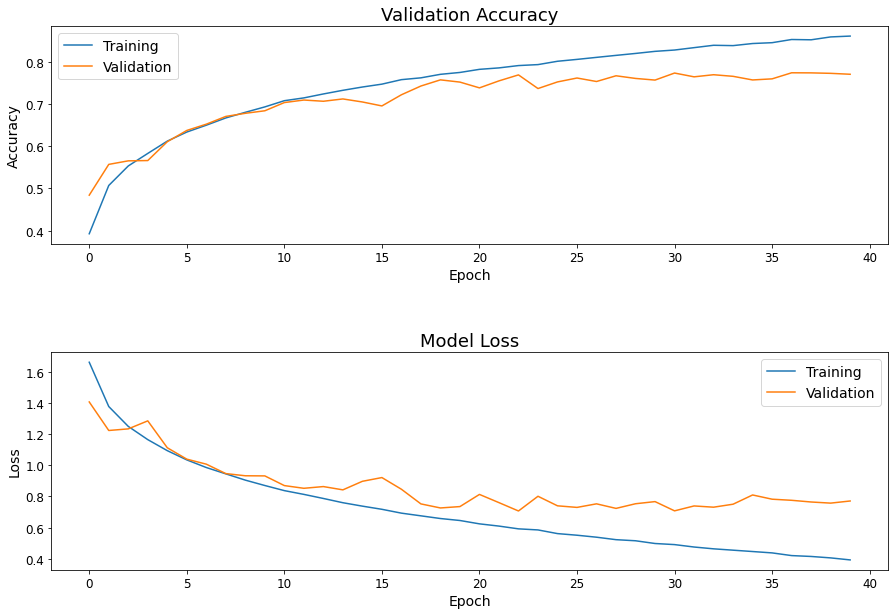

In [28]:
plot_history(history_da4, 'da4.png', metric='accuracy')

model.summary()

# **Data augmentation 5 - Rotation: 0.7; Zoom: Height: 0.8**

In [29]:
# load the data
(X_train, y_train), (X_test, y_test) = cifar10.load_data()

print('Image shape: {0}'.format(X_train.shape[1:]))
print('Total number of training samples: {0}'.format(X_train.shape[0]))
print('Total number of validation samples: {0}'.format(X_test.shape[0]))

X_train = X_train.reshape(-1,32,32,3)

## Normalization block
norm_layer = preprocessing.Normalization()
norm_layer.adapt(X_train)
X_train_n = norm_layer(X_train)
X_test_n = norm_layer(X_test)

# You can modify the data_augmentation variable below to add your
# data augmentation pipeline.
# By default we do not apply any augmentation (RandomZoom(0) is equivalent
# to not performing any augmentation)
data_augmentation = keras.Sequential(
    [   
        preprocessing.RandomRotation(0.7),
        preprocessing.RandomZoom(height_factor=0.8),
    ]
)
# We will use glorot_uniform as a initialization by default
initialization = 'glorot_uniform'
# Use the architecture given below, only modify it to add Dropout/BatchNorm
model = Sequential()
model.add(data_augmentation)
model.add(Conv2D(32, (3, 3), padding='same', kernel_initializer=initialization))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2), padding='same'))

model.add(Conv2D(64, (3, 3), padding='same', kernel_initializer=initialization))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2), padding='same'))

model.add(Conv2D(128, (3, 3), padding='same', kernel_initializer=initialization))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2), padding='same'))

model.add(Conv2D(256, (3, 3), padding='same', kernel_initializer=initialization))
model.add(Activation('relu'))
# As we use global average pooling, we don't need to use Flatten
model.add(GlobalAveragePooling2D())
model.add(Dense(10, kernel_initializer=initialization))
model.add(Activation('softmax'))


Y_train_class = np_utils.to_categorical(y_train, 10)
Y_test_class = np_utils.to_categorical(y_test, 10)
# By default use Adam with lr=3e-4. Change it to SGD when asked to
opt = Adam(lr=3e-4)
model.compile(loss='categorical_crossentropy',
              optimizer=opt,
              metrics=['accuracy'])
# Use 40 epochs as default value to plot your curves
history_da5 = model.fit(X_train_n, Y_train_class, epochs=40, validation_data=(X_test_n,Y_test_class))

model.save('/content/drive/MyDrive/dl-cw-03/dataAug/da5')

Image shape: (32, 32, 3)
Total number of training samples: 50000
Total number of validation samples: 10000
Epoch 1/40


/usr/local/lib/python3.8/dist-packages/keras/optimizers/optimizer_v2/adam.py:117: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


1563/1563 [==============================] - 40s 22ms/step - loss: 1.9712 - accuracy: 0.2656 - val_loss: 1.8357 - val_accuracy: 0.3224
Epoch 2/40
1563/1563 [==============================] - 34s 22ms/step - loss: 1.8105 - accuracy: 0.3431 - val_loss: 1.7373 - val_accuracy: 0.3712
Epoch 3/40
1563/1563 [==============================] - 34s 22ms/step - loss: 1.7329 - accuracy: 0.3706 - val_loss: 1.6476 - val_accuracy: 0.4093
Epoch 4/40
1563/1563 [==============================] - 34s 22ms/step - loss: 1.6756 - accuracy: 0.3956 - val_loss: 1.6100 - val_accuracy: 0.4232
Epoch 5/40
1563/1563 [==============================] - 34s 22ms/step - loss: 1.6344 - accuracy: 0.4108 - val_loss: 1.5734 - val_accuracy: 0.4299
Epoch 6/40
1563/1563 [==============================] - 34s 22ms/step - loss: 1.6002 - accuracy: 0.4243 - val_loss: 1.5442 - val_accuracy: 0.4430
Epoch 7/40
1563/1563 [==============================] - 34s 22ms/step - loss: 1.5725 - accuracy: 0.4370 - val_loss: 1.5324 - val_accura

Model: "sequential_33"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_32 (Sequential)  (None, 32, 32, 3)         0         
                                                                 
 conv2d_64 (Conv2D)          (None, 32, 32, 32)        896       
                                                                 
 activation_80 (Activation)  (None, 32, 32, 32)        0         
                                                                 
 max_pooling2d_48 (MaxPoolin  (None, 16, 16, 32)       0         
 g2D)                                                            
                                                                 
 conv2d_65 (Conv2D)          (None, 16, 16, 64)        18496     
                                                                 
 activation_81 (Activation)  (None, 16, 16, 64)        0         
                                                     

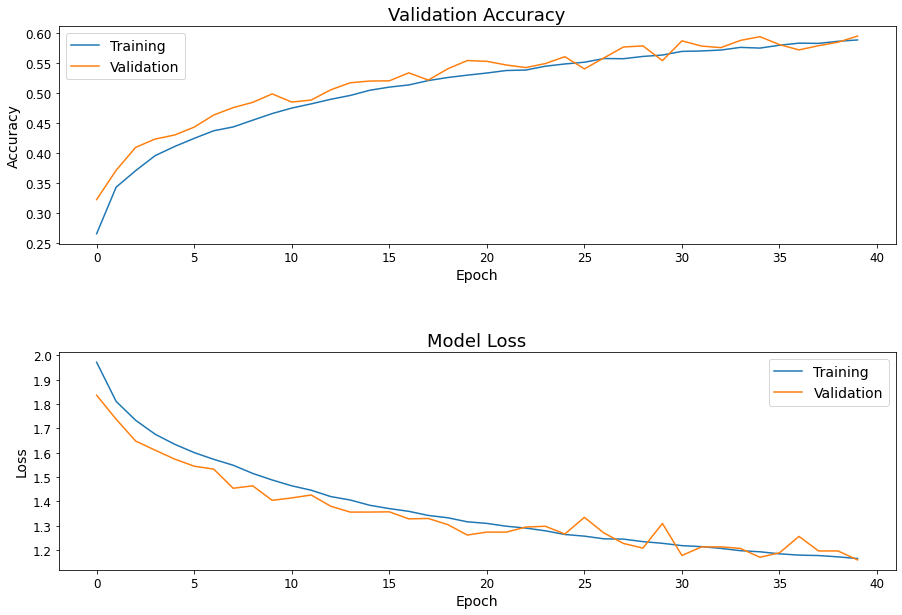

In [30]:
plot_history(history_da5, 'da5.png', metric='accuracy')

model.summary()

# **Baseline + Dropout**

In [63]:
print('Image shape: {0}'.format(X_train.shape[1:]))
print('Total number of training samples: {0}'.format(X_train.shape[0]))
print('Total number of validation samples: {0}'.format(X_test.shape[0]))

X_train = X_train.reshape(-1,32,32,3)

## Normalization block
norm_layer = preprocessing.Normalization()
norm_layer.adapt(X_train)
X_train_n = norm_layer(X_train)
X_test_n = norm_layer(X_test)

# You can modify the data_augmentation variable below to add your
# data augmentation pipeline.
# By default we do not apply any augmentation (RandomZoom(0) is equivalent
# to not performing any augmentation)
data_augmentation = keras.Sequential(
    [
        preprocessing.RandomZoom(0)
    ]
)
# We will use glorot_uniform as a initialization by default
initialization = 'glorot_uniform'
# Use the architecture given below, only modify it to add Dropout/BatchNorm
model = Sequential()
model.add(data_augmentation)
model.add(Conv2D(32, (3, 3), padding='same', kernel_initializer=initialization))
model.add(Activation('relu'))
model.add(Dropout(0.3))

model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2), padding='same'))

model.add(Conv2D(64, (3, 3), padding='same', kernel_initializer=initialization))
model.add(Activation('relu'))
model.add(Dropout(0.3))

model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2), padding='same'))

model.add(Conv2D(128, (3, 3), padding='same', kernel_initializer=initialization))
model.add(Activation('relu'))
model.add(Dropout(0.3))

model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2), padding='same'))

model.add(Conv2D(256, (3, 3), padding='same', kernel_initializer=initialization))
model.add(Activation('relu'))
model.add(Dropout(0.3))

# As we use global average pooling, we don't need to use Flatten
model.add(GlobalAveragePooling2D())
model.add(Dense(10, kernel_initializer=initialization))
model.add(Activation('softmax'))


Y_train_class = np_utils.to_categorical(y_train, 10)
Y_test_class = np_utils.to_categorical(y_test, 10)
# By default use Adam with lr=3e-4. Change it to SGD when asked to
opt = Adam(lr=3e-4)
model.compile(loss='categorical_crossentropy',
              optimizer=opt,
              metrics=['accuracy'])
# Use 40 epochs as default value to plot your curves
history_dropout = model.fit(X_train_n, Y_train_class, epochs=40, validation_data=(X_test_n,Y_test_class))

model.save('/content/drive/MyDrive/dl-cw-03/reg/dropout')

Image shape: (32, 32, 3)
Total number of training samples: 50000
Total number of validation samples: 10000
Epoch 1/40


/usr/local/lib/python3.8/dist-packages/keras/optimizers/optimizer_v2/adam.py:117: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


1563/1563 [==============================] - 38s 22ms/step - loss: 1.5537 - accuracy: 0.4349 - val_loss: 1.5316 - val_accuracy: 0.5088
Epoch 2/40
1563/1563 [==============================] - 34s 22ms/step - loss: 1.2068 - accuracy: 0.5713 - val_loss: 1.3665 - val_accuracy: 0.5682
Epoch 3/40
1563/1563 [==============================] - 34s 22ms/step - loss: 1.0558 - accuracy: 0.6257 - val_loss: 1.1972 - val_accuracy: 0.6247
Epoch 4/40
1563/1563 [==============================] - 34s 22ms/step - loss: 0.9492 - accuracy: 0.6648 - val_loss: 1.1043 - val_accuracy: 0.6759
Epoch 5/40
1563/1563 [==============================] - 34s 22ms/step - loss: 0.8662 - accuracy: 0.6949 - val_loss: 1.0294 - val_accuracy: 0.6794
Epoch 6/40
1563/1563 [==============================] - 34s 22ms/step - loss: 0.8048 - accuracy: 0.7153 - val_loss: 0.9883 - val_accuracy: 0.6973
Epoch 7/40
1563/1563 [==============================] - 34s 22ms/step - loss: 0.7499 - accuracy: 0.7382 - val_loss: 0.9054 - val_accura

Model: "sequential_15"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_14 (Sequential)  (None, 32, 32, 3)         0         
                                                                 
 conv2d_28 (Conv2D)          (None, 32, 32, 32)        896       
                                                                 
 activation_35 (Activation)  (None, 32, 32, 32)        0         
                                                                 
 dropout (Dropout)           (None, 32, 32, 32)        0         
                                                                 
 max_pooling2d_21 (MaxPoolin  (None, 16, 16, 32)       0         
 g2D)                                                            
                                                                 
 conv2d_29 (Conv2D)          (None, 16, 16, 64)        18496     
                                                     

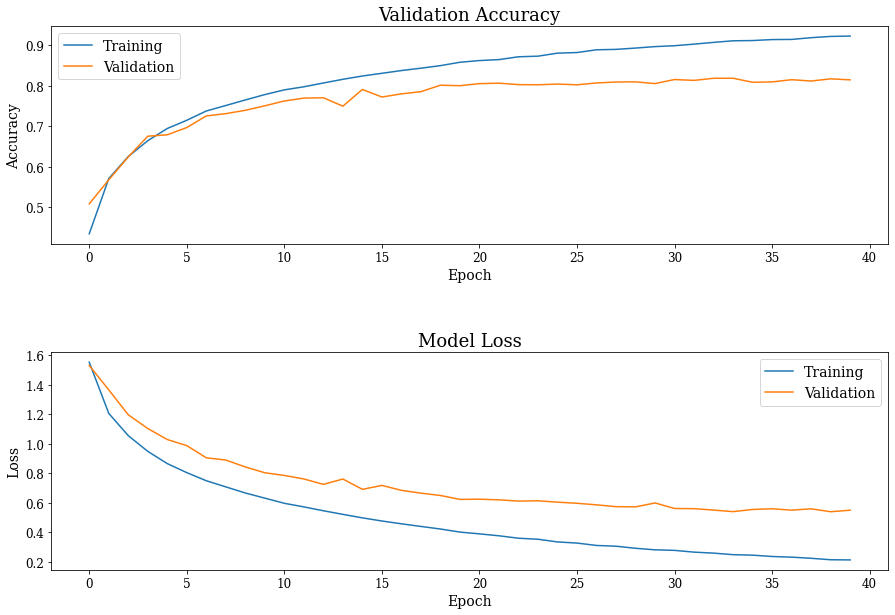

In [64]:
plot_history(history_dropout, 'dropout.png', metric='accuracy')
model.summary()

# **Baseline + Batch Normalization**

In [44]:
# load the data
(X_train, y_train), (X_test, y_test) = cifar10.load_data()

print('Image shape: {0}'.format(X_train.shape[1:]))
print('Total number of training samples: {0}'.format(X_train.shape[0]))
print('Total number of validation samples: {0}'.format(X_test.shape[0]))

X_train = X_train.reshape(-1,32,32,3)

## Normalization block
norm_layer = preprocessing.Normalization()
norm_layer.adapt(X_train)
X_train_n = norm_layer(X_train)
X_test_n = norm_layer(X_test)

# You can modify the data_augmentation variable below to add your
# data augmentation pipeline.
# By default we do not apply any augmentation (RandomZoom(0) is equivalent
# to not performing any augmentation)
data_augmentation = keras.Sequential(
    [
        preprocessing.RandomZoom(0)
    ]
)
# We will use glorot_uniform as a initialization by default
initialization = 'glorot_uniform'
# Use the architecture given below, only modify it to add Dropout/BatchNorm
model = Sequential()
model.add(data_augmentation)
model.add(Conv2D(32, (3, 3), padding='same', activation='relu', kernel_initializer=initialization))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2), padding='same'))

model.add(Conv2D(64, (3, 3), padding='same', activation='relu', kernel_initializer=initialization))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2), padding='same'))

model.add(Conv2D(128, (3, 3), padding='same', activation='relu', kernel_initializer=initialization))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2), padding='same'))

model.add(Conv2D(256, (3, 3), padding='same', activation='relu', kernel_initializer=initialization))
model.add(BatchNormalization())
# As we use global average pooling, we don't need to use Flatten
model.add(GlobalAveragePooling2D())
model.add(Dense(10, kernel_initializer=initialization))
model.add(Activation('softmax'))

Y_train_class = np_utils.to_categorical(y_train, 10)
Y_test_class = np_utils.to_categorical(y_test, 10)
# By default use Adam with lr=3e-4. Change it to SGD when asked to
opt = Adam(lr=3e-4)
model.compile(loss='categorical_crossentropy',
              optimizer=opt,
              metrics=['accuracy'])

# Use 40 epochs as default value to plot your curves
history_batchn = model.fit(X_train_n, Y_train_class, epochs=40, validation_data=(X_test_n,Y_test_class))

model.save('/content/drive/MyDrive/dl-cw-03/reg/batchn')

Image shape: (32, 32, 3)
Total number of training samples: 50000
Total number of validation samples: 10000
Epoch 1/40


/usr/local/lib/python3.8/dist-packages/keras/optimizers/optimizer_v2/adam.py:117: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


1563/1563 [==============================] - 42s 25ms/step - loss: 1.1885 - accuracy: 0.5771 - val_loss: 0.9329 - val_accuracy: 0.6756
Epoch 2/40
1563/1563 [==============================] - 39s 25ms/step - loss: 0.8294 - accuracy: 0.7136 - val_loss: 0.8060 - val_accuracy: 0.7135
Epoch 3/40
1563/1563 [==============================] - 39s 25ms/step - loss: 0.6627 - accuracy: 0.7753 - val_loss: 0.7368 - val_accuracy: 0.7437
Epoch 4/40
1563/1563 [==============================] - 39s 25ms/step - loss: 0.5418 - accuracy: 0.8161 - val_loss: 0.6909 - val_accuracy: 0.7593
Epoch 5/40
1563/1563 [==============================] - 39s 25ms/step - loss: 0.4453 - accuracy: 0.8506 - val_loss: 0.6720 - val_accuracy: 0.7738
Epoch 6/40
1563/1563 [==============================] - 39s 25ms/step - loss: 0.3577 - accuracy: 0.8814 - val_loss: 0.6474 - val_accuracy: 0.7804
Epoch 7/40
1563/1563 [==============================] - 41s 26ms/step - loss: 0.2839 - accuracy: 0.9084 - val_loss: 0.6938 - val_accura

Model: "sequential_47"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_46 (Sequential)  (None, 32, 32, 3)         0         
                                                                 
 conv2d_84 (Conv2D)          (None, 32, 32, 32)        896       
                                                                 
 batch_normalization_34 (Bat  (None, 32, 32, 32)       128       
 chNormalization)                                                
                                                                 
 max_pooling2d_63 (MaxPoolin  (None, 16, 16, 32)       0         
 g2D)                                                            
                                                                 
 conv2d_85 (Conv2D)          (None, 16, 16, 64)        18496     
                                                                 
 batch_normalization_35 (Bat  (None, 16, 16, 64)     

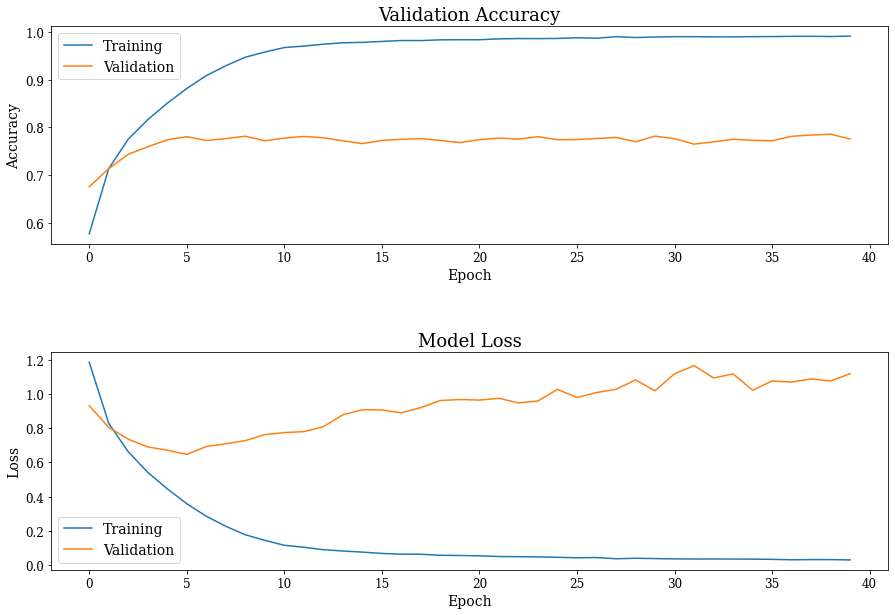

In [45]:
plot_history(history_batchn, 'batchn.png', metric='accuracy')
model.summary()

In [ ]:
# load the data
(X_train, y_train), (X_test, y_test) = cifar10.load_data()

print('Image shape: {0}'.format(X_train.shape[1:]))
print('Total number of training samples: {0}'.format(X_train.shape[0]))
print('Total number of validation samples: {0}'.format(X_test.shape[0]))

X_train = X_train.reshape(-1,32,32,3)

## Normalization block
norm_layer = preprocessing.Normalization()
norm_layer.adapt(X_train)
X_train_n = norm_layer(X_train)
X_test_n = norm_layer(X_test)

# You can modify the data_augmentation variable below to add your
# data augmentation pipeline.
# By default we do not apply any augmentation (RandomZoom(0) is equivalent
# to not performing any augmentation)
data_augmentation = keras.Sequential(
    [
        preprocessing.RandomZoom(0)
    ]
)
# We will use glorot_uniform as a initialization by default
initialization = 'glorot_uniform'
# Use the architecture given below, only modify it to add Dropout/BatchNorm
model = Sequential()
model.add(data_augmentation)
model.add(Conv2D(32, (3, 3), padding='same', activation='relu', kernel_initializer=initialization))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2), padding='same'))

model.add(Conv2D(64, (3, 3), padding='same', activation='relu', kernel_initializer=initialization))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2), padding='same'))

model.add(Conv2D(128, (3, 3), padding='same', activation='relu', kernel_initializer=initialization))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2), padding='same'))

model.add(Conv2D(256, (3, 3), padding='same', activation='relu', kernel_initializer=initialization))
model.add(BatchNormalization())
# As we use global average pooling, we don't need to use Flatten
model.add(GlobalAveragePooling2D())
model.add(Dense(10, kernel_initializer=initialization))
model.add(Activation('softmax'))

Y_train_class = np_utils.to_categorical(y_train, 10)
Y_test_class = np_utils.to_categorical(y_test, 10)
# By default use Adam with lr=3e-4. Change it to SGD when asked to
opt = Adam(lr=3e-4)
model.compile(loss='categorical_crossentropy',
              optimizer=opt,
              metrics=['accuracy'])

# Use 40 epochs as default value to plot your curves
history_batchn3 = model.fit(X_train_n, Y_train_class, epochs=40, batch=100, validation_data=(X_test_n,Y_test_class))

model.save('/content/drive/MyDrive/dl-cw-03/reg/batchn3')

In [10]:
# load the data
(X_train, y_train), (X_test, y_test) = cifar10.load_data()

print('Image shape: {0}'.format(X_train.shape[1:]))
print('Total number of training samples: {0}'.format(X_train.shape[0]))
print('Total number of validation samples: {0}'.format(X_test.shape[0]))

X_train = X_train.reshape(-1,32,32,3)

## Normalization block
norm_layer = preprocessing.Normalization()
norm_layer.adapt(X_train)
X_train_n = norm_layer(X_train)
X_test_n = norm_layer(X_test)

# You can modify the data_augmentation variable below to add your
# data augmentation pipeline.
# By default we do not apply any augmentation (RandomZoom(0) is equivalent
# to not performing any augmentation)
data_augmentation = keras.Sequential(
    [
        preprocessing.RandomZoom(0)
    ]
)
# We will use glorot_uniform as a initialization by default
initialization = 'glorot_uniform'
# Use the architecture given below, only modify it to add Dropout/BatchNorm
model = Sequential()
model.add(data_augmentation)
model.add(Conv2D(32, (3, 3), padding='same', kernel_initializer=initialization))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2), padding='same'))

model.add(Conv2D(64, (3, 3), padding='same', kernel_initializer=initialization))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2), padding='same'))

model.add(Conv2D(128, (3, 3), padding='same', kernel_initializer=initialization))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2), padding='same'))

model.add(Conv2D(256, (3, 3), padding='same', kernel_initializer=initialization))
model.add(BatchNormalization())
model.add(Activation('relu'))
# As we use global average pooling, we don't need to use Flatten
model.add(GlobalAveragePooling2D())
model.add(Dense(10, kernel_initializer=initialization))
model.add(BatchNormalization())
model.add(Activation('softmax'))

Y_train_class = np_utils.to_categorical(y_train, 10)
Y_test_class = np_utils.to_categorical(y_test, 10)
# By default use Adam with lr=3e-4. Change it to SGD when asked to
opt = Adam(lr=3e-4)
model.compile(loss='categorical_crossentropy',
              optimizer=opt,
              metrics=['accuracy'])

# Use 40 epochs as default value to plot your curves
history_batchn2 = model.fit(X_train_n, Y_train_class, epochs=40, validation_data=(X_test_n,Y_test_class))

model.save('/content/drive/MyDrive/dl-cw-03/reg/batchn2')

Image shape: (32, 32, 3)
Total number of training samples: 50000
Total number of validation samples: 10000
Epoch 1/40


/usr/local/lib/python3.8/dist-packages/keras/optimizers/optimizer_v2/adam.py:117: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


1563/1563 [==============================] - 46s 28ms/step - loss: 1.3330 - accuracy: 0.5632 - val_loss: 1.2182 - val_accuracy: 0.5893
Epoch 2/40
1563/1563 [==============================] - 44s 28ms/step - loss: 1.0184 - accuracy: 0.6833 - val_loss: 1.0412 - val_accuracy: 0.6529
Epoch 3/40
1563/1563 [==============================] - 43s 27ms/step - loss: 0.8673 - accuracy: 0.7291 - val_loss: 1.1743 - val_accuracy: 0.6150
Epoch 4/40
1563/1563 [==============================] - 43s 28ms/step - loss: 0.7584 - accuracy: 0.7611 - val_loss: 0.9582 - val_accuracy: 0.6741
Epoch 5/40
1563/1563 [==============================] - 43s 28ms/step - loss: 0.6702 - accuracy: 0.7912 - val_loss: 0.9595 - val_accuracy: 0.6755
Epoch 6/40
1563/1563 [==============================] - 43s 28ms/step - loss: 0.5970 - accuracy: 0.8133 - val_loss: 0.8573 - val_accuracy: 0.7246
Epoch 7/40
1563/1563 [==============================] - 43s 27ms/step - loss: 0.5362 - accuracy: 0.8321 - val_loss: 0.8616 - val_accura

Model: "sequential_11"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_10 (Sequential)  (None, 32, 32, 3)         0         
                                                                 
 conv2d_20 (Conv2D)          (None, 32, 32, 32)        896       
                                                                 
 batch_normalization_24 (Bat  (None, 32, 32, 32)       128       
 chNormalization)                                                
                                                                 
 activation_25 (Activation)  (None, 32, 32, 32)        0         
                                                                 
 max_pooling2d_15 (MaxPoolin  (None, 16, 16, 32)       0         
 g2D)                                                            
                                                                 
 conv2d_21 (Conv2D)          (None, 16, 16, 64)      

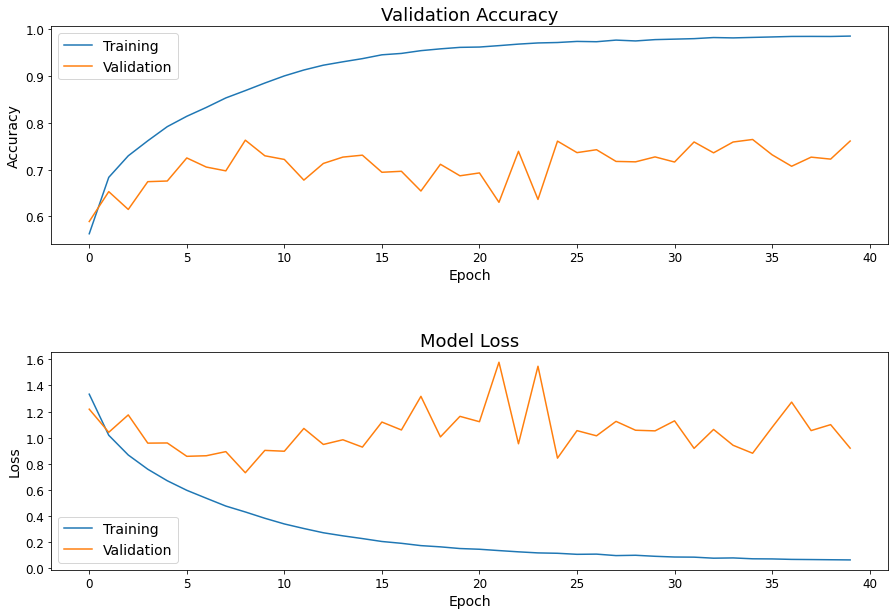

In [11]:
plot_history(history_batchn2, 'batchn2.png', metric='accuracy')
model.summary()

# **Baseline + Dropout + Batch Normalization** 

In [3]:
# load the data
(X_train, y_train), (X_test, y_test) = cifar10.load_data()

print('Image shape: {0}'.format(X_train.shape[1:]))
print('Total number of training samples: {0}'.format(X_train.shape[0]))
print('Total number of validation samples: {0}'.format(X_test.shape[0]))

X_train = X_train.reshape(-1,32,32,3)

## Normalization block
norm_layer = preprocessing.Normalization()
norm_layer.adapt(X_train)
X_train_n = norm_layer(X_train)
X_test_n = norm_layer(X_test)

# You can modify the data_augmentation variable below to add your
# data augmentation pipeline.
# By default we do not apply any augmentation (RandomZoom(0) is equivalent
# to not performing any augmentation)
data_augmentation = keras.Sequential(
    [
        preprocessing.RandomZoom(0)
    ]
)
# We will use glorot_uniform as a initialization by default
initialization = 'glorot_uniform'
# Use the architecture given below, only modify it to add Dropout/BatchNorm
model = Sequential()
model.add(data_augmentation)
model.add(Conv2D(32, (3, 3), padding='same', kernel_initializer=initialization))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.1))
model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2), padding='same'))

model.add(Conv2D(64, (3, 3), padding='same', kernel_initializer=initialization))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.1))
model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2), padding='same'))

model.add(Conv2D(128, (3, 3), padding='same', kernel_initializer=initialization))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.1))
model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2), padding='same'))

model.add(Conv2D(256, (3, 3), padding='same', kernel_initializer=initialization))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.1))
# As we use global average pooling, we don't need to use Flatten
model.add(GlobalAveragePooling2D())
model.add(Dense(10, kernel_initializer=initialization))
model.add(BatchNormalization())
model.add(Activation('softmax'))
model.add(Dropout(0.1))


Y_train_class = np_utils.to_categorical(y_train, 10)
Y_test_class = np_utils.to_categorical(y_test, 10)
# By default use Adam with lr=3e-4. Change it to SGD when asked to
opt = Adam(lr=3e-4)
model.compile(loss='categorical_crossentropy',
              optimizer=opt,
              metrics=['accuracy'])
# Use 40 epochs as default value to plot your curves
history_batchdrop = model.fit(X_train_n, Y_train_class, epochs=40, validation_data=(X_test_n,Y_test_class))

model.save('/content/drive/MyDrive/dl-cw-03/reg/batchdrop')

Image shape: (32, 32, 3)
Total number of training samples: 50000
Total number of validation samples: 10000
Epoch 1/40


1563/1563 [==============================] - 56s 34ms/step - loss: 2.7878 - accuracy: 0.5052 - val_loss: 1.3117 - val_accuracy: 0.5615
Epoch 2/40
1563/1563 [==============================] - 52s 33ms/step - loss: 2.5357 - accuracy: 0.6024 - val_loss: 1.1390 - val_accuracy: 0.6191
Epoch 3/40
1563/1563 [==============================] - 51s 33ms/step - loss: 2.4310 - accuracy: 0.6404 - val_loss: 0.9383 - val_accuracy: 0.7076
Epoch 4/40
1563/1563 [==============================] - 52s 33ms/step - loss: 2.3681 - accuracy: 0.6632 - val_loss: 1.0738 - val_accuracy: 0.6149
Epoch 5/40
1563/1563 [==============================] - 54s 35ms/step - loss: 2.2977 - accuracy: 0.6850 - val_loss: 0.9605 - val_accuracy: 0.6844
Epoch 6/40
1563/1563 [==============================] - 53s 34ms/step - loss: 2.2135 - accuracy: 0.7000 - val_loss: 0.9255 - val_accuracy: 0.6937
Epoch 7/40
1563/1563 [==============================] - 53s 34ms/step - loss: 2.1765 - accuracy: 0.7131 - val_loss: 0.8234 - val_accura

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_4 (Sequential)   (None, 32, 32, 3)         0         
                                                                 
 conv2d_8 (Conv2D)           (None, 32, 32, 32)        896       
                                                                 
 batch_normalization_10 (Bat  (None, 32, 32, 32)       128       
 chNormalization)                                                
                                                                 
 activation_10 (Activation)  (None, 32, 32, 32)        0         
                                                                 
 max_pooling2d_6 (MaxPooling  (None, 16, 16, 32)       0         
 2D)                                                             
                                                                 
 conv2d_9 (Conv2D)           (None, 16, 16, 64)       

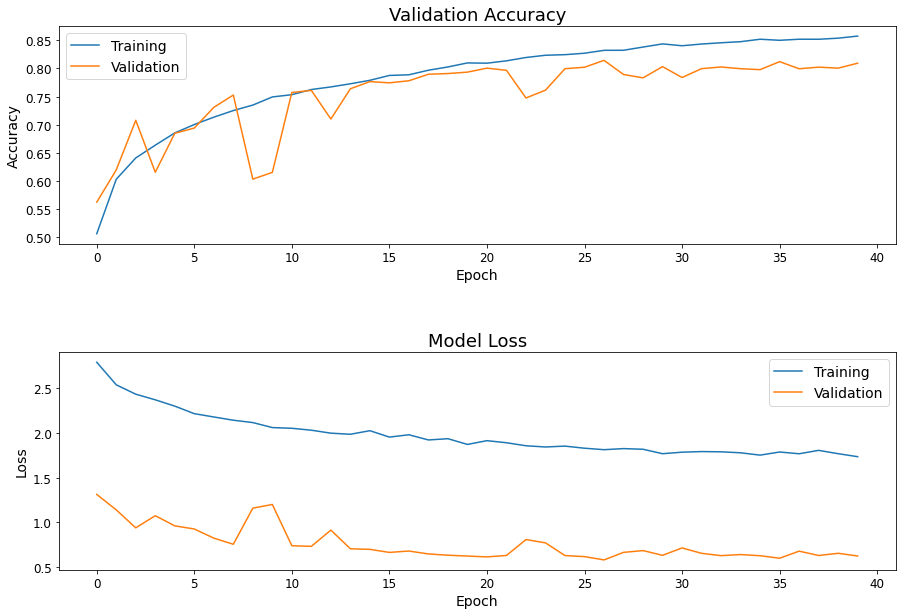

In [6]:
plot_history(history_batchdrop, 'batchdrop.png', metric='accuracy')
model.summary()

In [2]:
# load the data
(X_train, y_train), (X_test, y_test) = cifar10.load_data()

print('Image shape: {0}'.format(X_train.shape[1:]))
print('Total number of training samples: {0}'.format(X_train.shape[0]))
print('Total number of validation samples: {0}'.format(X_test.shape[0]))

X_train = X_train.reshape(-1,32,32,3)

## Normalization block
norm_layer = preprocessing.Normalization()
norm_layer.adapt(X_train)
X_train_n = norm_layer(X_train)
X_test_n = norm_layer(X_test)

# You can modify the data_augmentation variable below to add your
# data augmentation pipeline.
# By default we do not apply any augmentation (RandomZoom(0) is equivalent
# to not performing any augmentation)
data_augmentation = keras.Sequential(
    [
        preprocessing.RandomZoom(0)
    ]
)
# We will use glorot_uniform as a initialization by default
initialization = 'glorot_uniform'
# Use the architecture given below, only modify it to add Dropout/BatchNorm
model = Sequential()
model.add(data_augmentation)
model.add(Conv2D(32, (3, 3), padding='same', kernel_initializer=initialization))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.1))
model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2), padding='same'))

model.add(Conv2D(64, (3, 3), padding='same', kernel_initializer=initialization))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.1))
model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2), padding='same'))

model.add(Conv2D(128, (3, 3), padding='same', kernel_initializer=initialization))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.1))
model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2), padding='same'))

model.add(Conv2D(256, (3, 3), padding='same', kernel_initializer=initialization))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.1))
# As we use global average pooling, we don't need to use Flatten
model.add(GlobalAveragePooling2D())
model.add(Dense(10, kernel_initializer=initialization))
model.add(Activation('softmax'))


Y_train_class = np_utils.to_categorical(y_train, 10)
Y_test_class = np_utils.to_categorical(y_test, 10)
# By default use Adam with lr=3e-4. Change it to SGD when asked to
opt = Adam(lr=3e-4)
model.compile(loss='categorical_crossentropy',
              optimizer=opt,
              metrics=['accuracy'])
# Use 40 epochs as default value to plot your curves
history_batchdrop2 = model.fit(X_train_n, Y_train_class, epochs=40, validation_data=(X_test_n,Y_test_class))

model.save('/content/drive/MyDrive/dl-cw-03/reg/batchdrop2')

170498071/170498071 [==============================] - 2s 0us/step
Image shape: (32, 32, 3)
Total number of training samples: 50000
Total number of validation samples: 10000
Epoch 1/40


/usr/local/lib/python3.8/dist-packages/keras/optimizers/optimizer_v2/adam.py:117: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


1563/1563 [==============================] - 46s 27ms/step - loss: 1.2458 - accuracy: 0.5552 - val_loss: 1.1539 - val_accuracy: 0.5888
Epoch 2/40
1563/1563 [==============================] - 42s 27ms/step - loss: 0.9350 - accuracy: 0.6738 - val_loss: 1.1649 - val_accuracy: 0.5838
Epoch 3/40
1563/1563 [==============================] - 42s 27ms/step - loss: 0.7978 - accuracy: 0.7219 - val_loss: 0.9084 - val_accuracy: 0.6835
Epoch 4/40
1563/1563 [==============================] - 42s 27ms/step - loss: 0.7072 - accuracy: 0.7555 - val_loss: 0.8551 - val_accuracy: 0.6971
Epoch 5/40
1563/1563 [==============================] - 42s 27ms/step - loss: 0.6470 - accuracy: 0.7752 - val_loss: 0.8998 - val_accuracy: 0.6887
Epoch 6/40
1563/1563 [==============================] - 42s 27ms/step - loss: 0.5968 - accuracy: 0.7953 - val_loss: 0.7711 - val_accuracy: 0.7282
Epoch 7/40
1563/1563 [==============================] - 42s 27ms/step - loss: 0.5514 - accuracy: 0.8077 - val_loss: 0.9400 - val_accura

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (None, 32, 32, 3)         0         
                                                                 
 conv2d (Conv2D)             (None, 32, 32, 32)        896       
                                                                 
 batch_normalization (BatchN  (None, 32, 32, 32)       128       
 ormalization)                                                   
                                                                 
 activation (Activation)     (None, 32, 32, 32)        0         
                                                                 
 dropout (Dropout)           (None, 32, 32, 32)        0         
                                                                 
 max_pooling2d (MaxPooling2D  (None, 16, 16, 32)       0         
 )                                                    

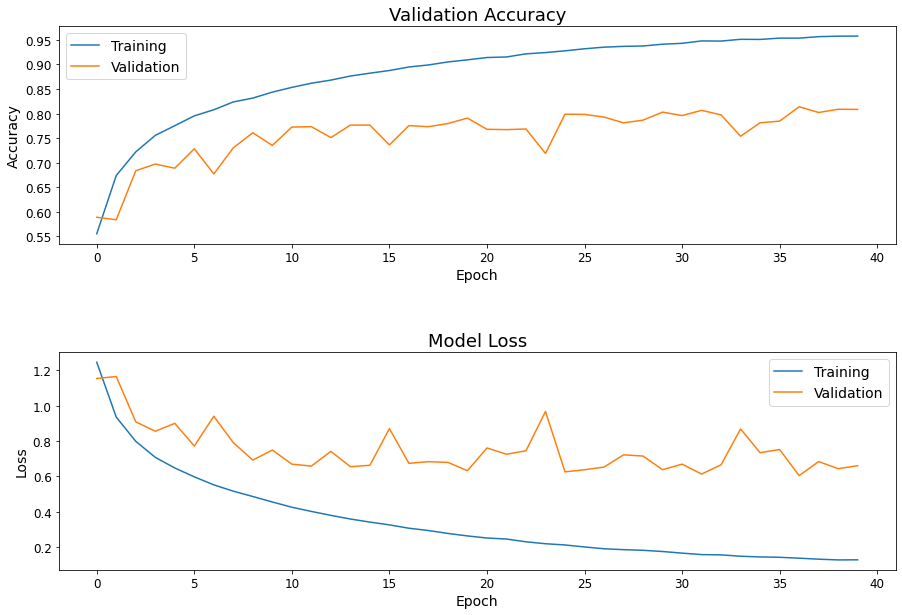

In [3]:
plot_history(history_batchdrop2, 'batchdrop2.png', metric='accuracy')
model.summary()

In [4]:
# load the data
(X_train, y_train), (X_test, y_test) = cifar10.load_data()

print('Image shape: {0}'.format(X_train.shape[1:]))
print('Total number of training samples: {0}'.format(X_train.shape[0]))
print('Total number of validation samples: {0}'.format(X_test.shape[0]))

X_train = X_train.reshape(-1,32,32,3)

## Normalization block
norm_layer = preprocessing.Normalization()
norm_layer.adapt(X_train)
X_train_n = norm_layer(X_train)
X_test_n = norm_layer(X_test)

# You can modify the data_augmentation variable below to add your
# data augmentation pipeline.
# By default we do not apply any augmentation (RandomZoom(0) is equivalent
# to not performing any augmentation)
data_augmentation = keras.Sequential(
    [
        preprocessing.RandomZoom(0)
    ]
)
# We will use glorot_uniform as a initialization by default
initialization = 'glorot_uniform'
# Use the architecture given below, only modify it to add Dropout/BatchNorm
model = Sequential()
model.add(data_augmentation)
model.add(Conv2D(32, (3, 3), padding='same', kernel_initializer=initialization))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2), padding='same'))

model.add(Conv2D(64, (3, 3), padding='same', kernel_initializer=initialization))
model.add(Activation('relu'))
model.add(Dropout(0.3))
model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2), padding='same'))

model.add(Conv2D(128, (3, 3), padding='same', kernel_initializer=initialization))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2), padding='same'))

model.add(Conv2D(256, (3, 3), padding='same', kernel_initializer=initialization))
model.add(Activation('relu'))
model.add(Dropout(0.3))
# As we use global average pooling, we don't need to use Flatten
model.add(GlobalAveragePooling2D())
model.add(Dense(10, kernel_initializer=initialization))
model.add(Activation('softmax'))


Y_train_class = np_utils.to_categorical(y_train, 10)
Y_test_class = np_utils.to_categorical(y_test, 10)
# By default use Adam with lr=3e-4. Change it to SGD when asked to
opt = Adam(lr=3e-4)
model.compile(loss='categorical_crossentropy',
              optimizer=opt,
              metrics=['accuracy'])
# Use 40 epochs as default value to plot your curves
history_batchdrop3 = model.fit(X_train_n, Y_train_class, epochs=40, validation_data=(X_test_n,Y_test_class))

model.save('/content/drive/MyDrive/dl-cw-03/reg/batchdrop3')

Image shape: (32, 32, 3)
Total number of training samples: 50000
Total number of validation samples: 10000
Epoch 1/40


/usr/local/lib/python3.8/dist-packages/keras/optimizers/optimizer_v2/adam.py:117: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


1563/1563 [==============================] - 36s 22ms/step - loss: 1.3960 - accuracy: 0.4919 - val_loss: 1.1841 - val_accuracy: 0.5699
Epoch 2/40
1563/1563 [==============================] - 33s 21ms/step - loss: 1.0503 - accuracy: 0.6276 - val_loss: 1.0436 - val_accuracy: 0.6194
Epoch 3/40
1563/1563 [==============================] - 33s 21ms/step - loss: 0.9027 - accuracy: 0.6801 - val_loss: 0.9215 - val_accuracy: 0.6736
Epoch 4/40
1563/1563 [==============================] - 34s 22ms/step - loss: 0.8053 - accuracy: 0.7154 - val_loss: 0.8226 - val_accuracy: 0.7105
Epoch 5/40
1563/1563 [==============================] - 33s 21ms/step - loss: 0.7373 - accuracy: 0.7415 - val_loss: 0.8357 - val_accuracy: 0.7145
Epoch 6/40
1563/1563 [==============================] - 33s 21ms/step - loss: 0.6837 - accuracy: 0.7630 - val_loss: 0.7477 - val_accuracy: 0.7365
Epoch 7/40
1563/1563 [==============================] - 33s 21ms/step - loss: 0.6394 - accuracy: 0.7768 - val_loss: 0.7854 - val_accura

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_2 (Sequential)   (None, 32, 32, 3)         0         
                                                                 
 conv2d_4 (Conv2D)           (None, 32, 32, 32)        896       
                                                                 
 batch_normalization_4 (Batc  (None, 32, 32, 32)       128       
 hNormalization)                                                 
                                                                 
 activation_5 (Activation)   (None, 32, 32, 32)        0         
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 16, 16, 32)       0         
 2D)                                                             
                                                                 
 conv2d_5 (Conv2D)           (None, 16, 16, 64)       

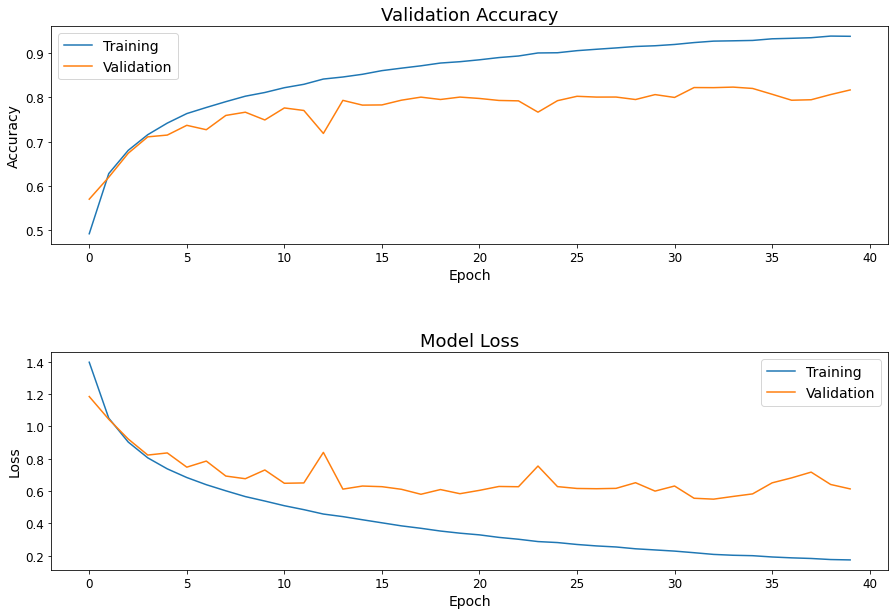

In [5]:
plot_history(history_batchdrop3, 'batchdrop3.png', metric='accuracy')
model.summary()

In [12]:
# load the data
(X_train, y_train), (X_test, y_test) = cifar10.load_data()

print('Image shape: {0}'.format(X_train.shape[1:]))
print('Total number of training samples: {0}'.format(X_train.shape[0]))
print('Total number of validation samples: {0}'.format(X_test.shape[0]))

X_train = X_train.reshape(-1,32,32,3)

## Normalization block
norm_layer = preprocessing.Normalization()
norm_layer.adapt(X_train)
X_train_n = norm_layer(X_train)
X_test_n = norm_layer(X_test)

# You can modify the data_augmentation variable below to add your
# data augmentation pipeline.
# By default we do not apply any augmentation (RandomZoom(0) is equivalent
# to not performing any augmentation)
data_augmentation = keras.Sequential(
    [
        preprocessing.RandomZoom(0)
    ]
)
# We will use glorot_uniform as a initialization by default
initialization = 'glorot_uniform'
# Use the architecture given below, only modify it to add Dropout/BatchNorm
model = Sequential()
model.add(data_augmentation)
model.add(Conv2D(32, (3, 3), padding='same', kernel_initializer=initialization))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.15))
model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2), padding='same'))

model.add(Conv2D(64, (3, 3), padding='same', kernel_initializer=initialization))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.15))
model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2), padding='same'))

model.add(Conv2D(128, (3, 3), padding='same', kernel_initializer=initialization))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.15))
model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2), padding='same'))

model.add(Conv2D(256, (3, 3), padding='same', kernel_initializer=initialization))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.15))
# As we use global average pooling, we don't need to use Flatten
model.add(GlobalAveragePooling2D())
model.add(Dense(10, kernel_initializer=initialization))
model.add(BatchNormalization())
model.add(Activation('softmax'))


Y_train_class = np_utils.to_categorical(y_train, 10)
Y_test_class = np_utils.to_categorical(y_test, 10)
# By default use Adam with lr=3e-4. Change it to SGD when asked to
opt = Adam(lr=3e-4)
model.compile(loss='categorical_crossentropy',
              optimizer=opt,
              metrics=['accuracy'])
# Use 40 epochs as default value to plot your curves
history_batchdrop4 = model.fit(X_train_n, Y_train_class, epochs=40, validation_data=(X_test_n,Y_test_class))

model.save('/content/drive/MyDrive/dl-cw-03/reg/batchdrop4')

Image shape: (32, 32, 3)
Total number of training samples: 50000
Total number of validation samples: 10000
Epoch 1/40


/usr/local/lib/python3.8/dist-packages/keras/optimizers/optimizer_v2/adam.py:117: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


1563/1563 [==============================] - 55s 33ms/step - loss: 1.3746 - accuracy: 0.5422 - val_loss: 1.5410 - val_accuracy: 0.4647
Epoch 2/40
1563/1563 [==============================] - 52s 33ms/step - loss: 1.0740 - accuracy: 0.6538 - val_loss: 1.3482 - val_accuracy: 0.5098
Epoch 3/40
1563/1563 [==============================] - 52s 33ms/step - loss: 0.9402 - accuracy: 0.6965 - val_loss: 1.0521 - val_accuracy: 0.6706
Epoch 4/40
1563/1563 [==============================] - 53s 34ms/step - loss: 0.8439 - accuracy: 0.7269 - val_loss: 1.1641 - val_accuracy: 0.6019
Epoch 5/40
1563/1563 [==============================] - 52s 33ms/step - loss: 0.7766 - accuracy: 0.7486 - val_loss: 1.0069 - val_accuracy: 0.6583
Epoch 6/40
1563/1563 [==============================] - 52s 33ms/step - loss: 0.7161 - accuracy: 0.7665 - val_loss: 0.8968 - val_accuracy: 0.6977
Epoch 7/40
1563/1563 [==============================] - 52s 33ms/step - loss: 0.6754 - accuracy: 0.7806 - val_loss: 0.9038 - val_accura

Model: "sequential_13"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_12 (Sequential)  (None, 32, 32, 3)         0         
                                                                 
 conv2d_24 (Conv2D)          (None, 32, 32, 32)        896       
                                                                 
 batch_normalization_29 (Bat  (None, 32, 32, 32)       128       
 chNormalization)                                                
                                                                 
 activation_30 (Activation)  (None, 32, 32, 32)        0         
                                                                 
 dropout_14 (Dropout)        (None, 32, 32, 32)        0         
                                                                 
 max_pooling2d_18 (MaxPoolin  (None, 16, 16, 32)       0         
 g2D)                                                

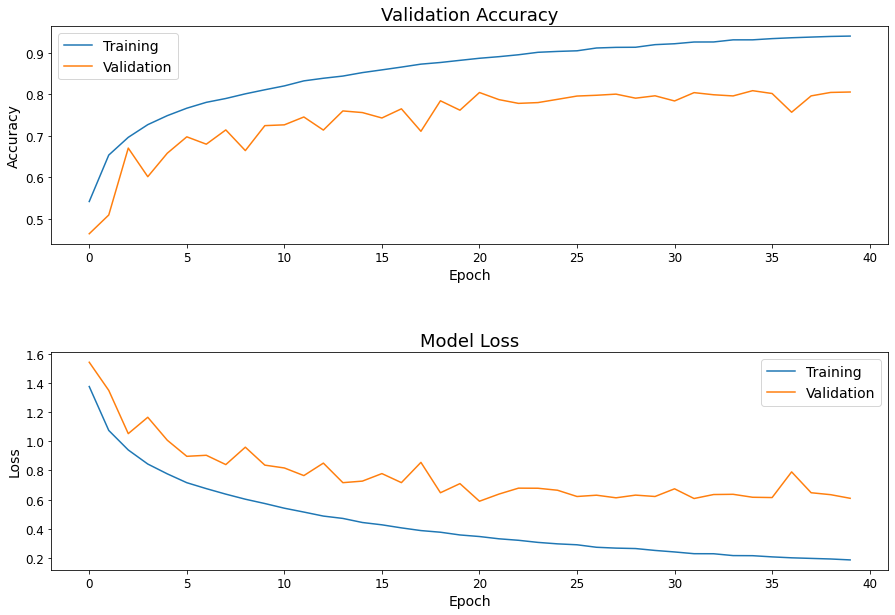

In [13]:
plot_history(history_batchdrop4, 'batchdrop4.png', metric='accuracy')
model.summary()

In [2]:
# load the data
(X_train, y_train), (X_test, y_test) = cifar10.load_data()

print('Image shape: {0}'.format(X_train.shape[1:]))
print('Total number of training samples: {0}'.format(X_train.shape[0]))
print('Total number of validation samples: {0}'.format(X_test.shape[0]))

X_train = X_train.reshape(-1,32,32,3)

## Normalization block
norm_layer = preprocessing.Normalization()
norm_layer.adapt(X_train)
X_train_n = norm_layer(X_train)
X_test_n = norm_layer(X_test)

# You can modify the data_augmentation variable below to add your
# data augmentation pipeline.
# By default we do not apply any augmentation (RandomZoom(0) is equivalent
# to not performing any augmentation)
data_augmentation = keras.Sequential(
    [
        preprocessing.RandomZoom(0)
    ]
)
# We will use glorot_uniform as a initialization by default
initialization = 'glorot_uniform'
# Use the architecture given below, only modify it to add Dropout/BatchNorm
model = Sequential()
model.add(data_augmentation)
model.add(BatchNormalization())
model.add(Conv2D(32, (3, 3), padding='same', kernel_initializer=initialization))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2), padding='same'))

model.add(Conv2D(64, (3, 3), padding='same', kernel_initializer=initialization))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2), padding='same'))

model.add(Conv2D(128, (3, 3), padding='same', kernel_initializer=initialization))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2), padding='same'))

model.add(Conv2D(256, (3, 3), padding='same', kernel_initializer=initialization))
model.add(Activation('relu'))
model.add(Dropout(0.5))
# As we use global average pooling, we don't need to use Flatten
model.add(GlobalAveragePooling2D())
model.add(Dense(10, kernel_initializer=initialization))
model.add(Activation('softmax'))


Y_train_class = np_utils.to_categorical(y_train, 10)
Y_test_class = np_utils.to_categorical(y_test, 10)
# By default use Adam with lr=3e-4. Change it to SGD when asked to
opt = Adam(lr=3e-4)
model.compile(loss='categorical_crossentropy',
              optimizer=opt,
              metrics=['accuracy'])
# Use 40 epochs as default value to plot your curves
history_batchdrop5 = model.fit(X_train_n, Y_train_class, epochs=40, validation_data=(X_test_n,Y_test_class))

model.save('/content/drive/MyDrive/dl-cw-03/reg/batchdrop5')

170498071/170498071 [==============================] - 2s 0us/step
Image shape: (32, 32, 3)
Total number of training samples: 50000
Total number of validation samples: 10000


/usr/local/lib/python3.8/dist-packages/keras/optimizers/optimizer_v2/adam.py:117: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


Epoch 1/40


1563/1563 [==============================] - 35s 21ms/step - loss: 1.5885 - accuracy: 0.4190 - val_loss: 1.2995 - val_accuracy: 0.5360
Epoch 2/40
1563/1563 [==============================] - 32s 21ms/step - loss: 1.2243 - accuracy: 0.5634 - val_loss: 1.0985 - val_accuracy: 0.6130
Epoch 3/40
1563/1563 [==============================] - 32s 21ms/step - loss: 1.0615 - accuracy: 0.6247 - val_loss: 1.0166 - val_accuracy: 0.6394
Epoch 4/40
1563/1563 [==============================] - 32s 21ms/step - loss: 0.9461 - accuracy: 0.6669 - val_loss: 0.8908 - val_accuracy: 0.6843
Epoch 5/40
1563/1563 [==============================] - 32s 20ms/step - loss: 0.8620 - accuracy: 0.6973 - val_loss: 0.8546 - val_accuracy: 0.6961
Epoch 6/40
1563/1563 [==============================] - 32s 20ms/step - loss: 0.7920 - accuracy: 0.7217 - val_loss: 0.8078 - val_accuracy: 0.7154
Epoch 7/40
1563/1563 [==============================] - 33s 21ms/step - loss: 0.7319 - accuracy: 0.7435 - val_loss: 0.7744 - val_accura

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (None, 32, 32, 3)         0         
                                                                 
 batch_normalization (BatchN  (None, 32, 32, 3)        12        
 ormalization)                                                   
                                                                 
 conv2d (Conv2D)             (None, 32, 32, 32)        896       
                                                                 
 activation (Activation)     (None, 32, 32, 32)        0         
                                                                 
 max_pooling2d (MaxPooling2D  (None, 16, 16, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 16, 16, 64)       

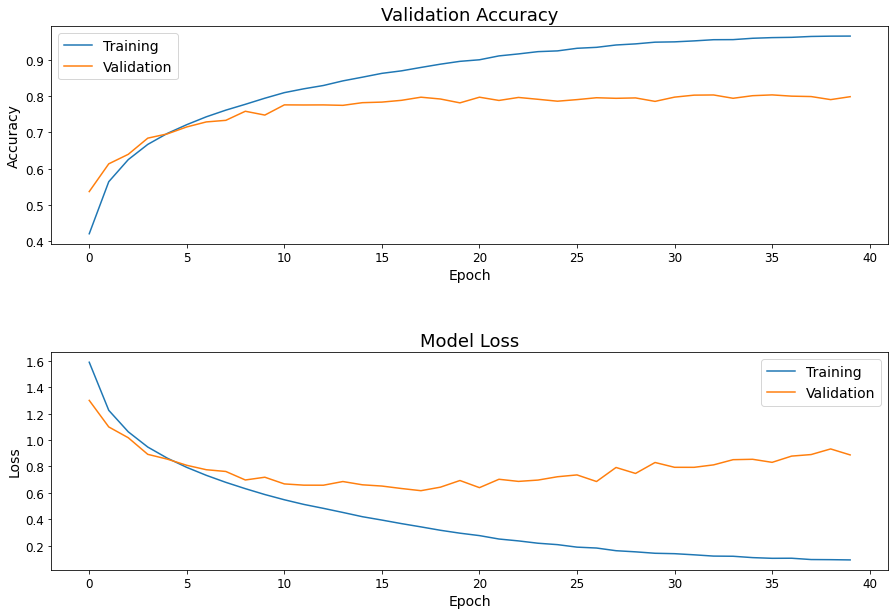

In [3]:
plot_history(history_batchdrop5, 'batchdrop5.png', metric='accuracy')
model.summary()

# ``zeros`` for the kernel initialization

In [46]:
# load the data
(X_train, y_train), (X_test, y_test) = cifar10.load_data()

print('Image shape: {0}'.format(X_train.shape[1:]))
print('Total number of training samples: {0}'.format(X_train.shape[0]))
print('Total number of validation samples: {0}'.format(X_test.shape[0]))

X_train = X_train.reshape(-1,32,32,3)

## Normalization block
norm_layer = preprocessing.Normalization()
norm_layer.adapt(X_train)
X_train_n = norm_layer(X_train)
X_test_n = norm_layer(X_test)

# You can modify the data_augmentation variable below to add your
# data augmentation pipeline.
# By default we do not apply any augmentation (RandomZoom(0) is equivalent
# to not performing any augmentation)
data_augmentation = keras.Sequential(
    [
        preprocessing.RandomZoom(0)
    ]
)
# We will use glorot_uniform as a initialization by default
initialization = 'zeros'
# Use the architecture given below, only modify it to add Dropout/BatchNorm
model = Sequential()
model.add(data_augmentation)
model.add(Conv2D(32, (3, 3), padding='same', kernel_initializer=initialization))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2), padding='same'))

model.add(Conv2D(64, (3, 3), padding='same', kernel_initializer=initialization))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2), padding='same'))

model.add(Conv2D(128, (3, 3), padding='same', kernel_initializer=initialization))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2), padding='same'))

model.add(Conv2D(256, (3, 3), padding='same', kernel_initializer=initialization))
model.add(Activation('relu'))
# As we use global average pooling, we don't need to use Flatten
model.add(GlobalAveragePooling2D())
model.add(Dense(10, kernel_initializer=initialization))
model.add(Activation('softmax'))


Y_train_class = np_utils.to_categorical(y_train, 10)
Y_test_class = np_utils.to_categorical(y_test, 10)
# By default use Adam with lr=3e-4. Change it to SGD when asked to
opt = Adam(lr=3e-4)
model.compile(loss='categorical_crossentropy',
              optimizer=opt,
              metrics=['accuracy'])

# Use 40 epochs as default value to plot your curves
history_zeros = model.fit(X_train_n, Y_train_class, epochs=40, validation_data=(X_test_n,Y_test_class))

model.save('/content/drive/MyDrive/dl-cw-03/initialisation/zeros')

Image shape: (32, 32, 3)
Total number of training samples: 50000
Total number of validation samples: 10000
Epoch 1/40


/usr/local/lib/python3.8/dist-packages/keras/optimizers/optimizer_v2/adam.py:117: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


1563/1563 [==============================] - 30s 18ms/step - loss: 2.3027 - accuracy: 0.0978 - val_loss: 2.3026 - val_accuracy: 0.1000
Epoch 2/40
1563/1563 [==============================] - 28s 18ms/step - loss: 2.3027 - accuracy: 0.0972 - val_loss: 2.3026 - val_accuracy: 0.1000
Epoch 3/40
1563/1563 [==============================] - 27s 17ms/step - loss: 2.3027 - accuracy: 0.0976 - val_loss: 2.3026 - val_accuracy: 0.1000
Epoch 4/40
1563/1563 [==============================] - 27s 17ms/step - loss: 2.3027 - accuracy: 0.0976 - val_loss: 2.3026 - val_accuracy: 0.1000
Epoch 5/40
1563/1563 [==============================] - 27s 17ms/step - loss: 2.3027 - accuracy: 0.0975 - val_loss: 2.3026 - val_accuracy: 0.1000
Epoch 6/40
1563/1563 [==============================] - 27s 17ms/step - loss: 2.3027 - accuracy: 0.0983 - val_loss: 2.3026 - val_accuracy: 0.1000
Epoch 7/40
1563/1563 [==============================] - 27s 17ms/step - loss: 2.3027 - accuracy: 0.0975 - val_loss: 2.3026 - val_accura

KeyboardInterrupt: ignored

In [ ]:
plot_history(history_zeros, 'zeros.png', metric='accuracy')
model.summary()

# **SGD as optimizer, learning rate = 3e-3**

In [ ]:
# load the data
(X_train, y_train), (X_test, y_test) = cifar10.load_data()

print('Image shape: {0}'.format(X_train.shape[1:]))
print('Total number of training samples: {0}'.format(X_train.shape[0]))
print('Total number of validation samples: {0}'.format(X_test.shape[0]))

X_train = X_train.reshape(-1,32,32,3)

## Normalization block
norm_layer = preprocessing.Normalization()
norm_layer.adapt(X_train)
X_train_n = norm_layer(X_train)
X_test_n = norm_layer(X_test)

# You can modify the data_augmentation variable below to add your
# data augmentation pipeline.
# By default we do not apply any augmentation (RandomZoom(0) is equivalent
# to not performing any augmentation)
data_augmentation = keras.Sequential(
    [
        preprocessing.RandomZoom(0)
    ]
)
# We will use glorot_uniform as a initialization by default
initialization = 'glorot_uniform'
# Use the architecture given below, only modify it to add Dropout/BatchNorm
model = Sequential()
model.add(data_augmentation)
model.add(Conv2D(32, (3, 3), padding='same', kernel_initializer=initialization))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2), padding='same'))

model.add(Conv2D(64, (3, 3), padding='same', kernel_initializer=initialization))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2), padding='same'))

model.add(Conv2D(128, (3, 3), padding='same', kernel_initializer=initialization))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2), padding='same'))

model.add(Conv2D(256, (3, 3), padding='same', kernel_initializer=initialization))
model.add(Activation('relu'))
# As we use global average pooling, we don't need to use Flatten
model.add(GlobalAveragePooling2D())
model.add(Dense(10, kernel_initializer=initialization))
model.add(Activation('softmax'))


Y_train_class = np_utils.to_categorical(y_train, 10)
Y_test_class = np_utils.to_categorical(y_test, 10)
# By default use Adam with lr=3e-4. Change it to SGD when asked to
opt = SGD(lr=3e-3)
model.compile(loss='categorical_crossentropy',
              optimizer=opt,
              metrics=['accuracy'])

# Use 40 epochs as default value to plot your curves
history_sgd1 = model.fit(X_train_n, Y_train_class, epochs=40, validation_data=(X_test_n,Y_test_class))

model.save('/content/drive/MyDrive/dl-cw-03/sgd/sgd1')

Image shape: (32, 32, 3)
Total number of training samples: 50000
Total number of validation samples: 10000
Epoch 1/40


/usr/local/lib/python3.8/dist-packages/keras/optimizers/optimizer_v2/gradient_descent.py:114: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


1563/1563 [==============================] - 31s 18ms/step - loss: 2.1775 - accuracy: 0.1887 - val_loss: 1.9977 - val_accuracy: 0.2784
Epoch 2/40
1563/1563 [==============================] - 28s 18ms/step - loss: 1.9033 - accuracy: 0.3096 - val_loss: 1.8362 - val_accuracy: 0.3268
Epoch 3/40
1563/1563 [==============================] - 28s 18ms/step - loss: 1.7456 - accuracy: 0.3627 - val_loss: 1.6682 - val_accuracy: 0.3905
Epoch 4/40
1563/1563 [==============================] - 27s 18ms/step - loss: 1.6381 - accuracy: 0.3995 - val_loss: 1.6172 - val_accuracy: 0.4071
Epoch 5/40
1563/1563 [==============================] - 27s 17ms/step - loss: 1.5694 - accuracy: 0.4298 - val_loss: 1.5394 - val_accuracy: 0.4343
Epoch 6/40
1563/1563 [==============================] - 27s 17ms/step - loss: 1.5137 - accuracy: 0.4509 - val_loss: 1.4813 - val_accuracy: 0.4636
Epoch 7/40
1563/1563 [==============================] - 27s 17ms/step - loss: 1.4671 - accuracy: 0.4693 - val_loss: 1.4813 - val_accura

In [ ]:
plot_history(history_sgd1, 'sgd1.png', metric='accuracy')
model.summary()

# **SGD as optimizer, learning rate = 1e-3**

In [ ]:
# load the data
(X_train, y_train), (X_test, y_test) = cifar10.load_data()

print('Image shape: {0}'.format(X_train.shape[1:]))
print('Total number of training samples: {0}'.format(X_train.shape[0]))
print('Total number of validation samples: {0}'.format(X_test.shape[0]))

X_train = X_train.reshape(-1,32,32,3)

## Normalization block
norm_layer = preprocessing.Normalization()
norm_layer.adapt(X_train)
X_train_n = norm_layer(X_train)
X_test_n = norm_layer(X_test)

# You can modify the data_augmentation variable below to add your
# data augmentation pipeline.
# By default we do not apply any augmentation (RandomZoom(0) is equivalent
# to not performing any augmentation)
data_augmentation = keras.Sequential(
    [
        preprocessing.RandomZoom(0)
    ]
)
# We will use glorot_uniform as a initialization by default
initialization = 'glorot_uniform'
# Use the architecture given below, only modify it to add Dropout/BatchNorm
model = Sequential()
model.add(data_augmentation)
model.add(Conv2D(32, (3, 3), padding='same', kernel_initializer=initialization))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2), padding='same'))

model.add(Conv2D(64, (3, 3), padding='same', kernel_initializer=initialization))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2), padding='same'))

model.add(Conv2D(128, (3, 3), padding='same', kernel_initializer=initialization))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2), padding='same'))

model.add(Conv2D(256, (3, 3), padding='same', kernel_initializer=initialization))
model.add(Activation('relu'))
# As we use global average pooling, we don't need to use Flatten
model.add(GlobalAveragePooling2D())
model.add(Dense(10, kernel_initializer=initialization))
model.add(Activation('softmax'))


Y_train_class = np_utils.to_categorical(y_train, 10)
Y_test_class = np_utils.to_categorical(y_test, 10)
# By default use Adam with lr=3e-4. Change it to SGD when asked to
opt = SGD(lr=1e-3)
model.compile(loss='categorical_crossentropy',
              optimizer=opt,
              metrics=['accuracy'])

# Use 40 epochs as default value to plot your curves
history_sgd2 = model.fit(X_train_n, Y_train_class, epochs=40, validation_data=(X_test_n,Y_test_class))

model.save('/content/drive/MyDrive/dl-cw-03/sgd/sgd2')

In [ ]:
plot_history(history_sgd2, 'sgd2.png', metric='accuracy')
model.summary()

# **SGD as optimizer, learning rate = 3e-4**

In [ ]:
# load the data
(X_train, y_train), (X_test, y_test) = cifar10.load_data()

print('Image shape: {0}'.format(X_train.shape[1:]))
print('Total number of training samples: {0}'.format(X_train.shape[0]))
print('Total number of validation samples: {0}'.format(X_test.shape[0]))

X_train = X_train.reshape(-1,32,32,3)

## Normalization block
norm_layer = preprocessing.Normalization()
norm_layer.adapt(X_train)
X_train_n = norm_layer(X_train)
X_test_n = norm_layer(X_test)

# You can modify the data_augmentation variable below to add your
# data augmentation pipeline.
# By default we do not apply any augmentation (RandomZoom(0) is equivalent
# to not performing any augmentation)
data_augmentation = keras.Sequential(
    [
        preprocessing.RandomZoom(0)
    ]
)
# We will use glorot_uniform as a initialization by default
initialization = 'glorot_uniform'
# Use the architecture given below, only modify it to add Dropout/BatchNorm
model = Sequential()
model.add(data_augmentation)
model.add(Conv2D(32, (3, 3), padding='same', kernel_initializer=initialization))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2), padding='same'))

model.add(Conv2D(64, (3, 3), padding='same', kernel_initializer=initialization))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2), padding='same'))

model.add(Conv2D(128, (3, 3), padding='same', kernel_initializer=initialization))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2), padding='same'))

model.add(Conv2D(256, (3, 3), padding='same', kernel_initializer=initialization))
model.add(Activation('relu'))
# As we use global average pooling, we don't need to use Flatten
model.add(GlobalAveragePooling2D())
model.add(Dense(10, kernel_initializer=initialization))
model.add(Activation('softmax'))


Y_train_class = np_utils.to_categorical(y_train, 10)
Y_test_class = np_utils.to_categorical(y_test, 10)
# By default use Adam with lr=3e-4. Change it to SGD when asked to
opt = SGD(lr=3e-4)
model.compile(loss='categorical_crossentropy',
              optimizer=opt,
              metrics=['accuracy'])

# Use 40 epochs as default value to plot your curves
history_sgd3 = model.fit(X_train_n, Y_train_class, epochs=40, validation_data=(X_test_n,Y_test_class))

model.save('/content/drive/MyDrive/dl-cw-03/sgd/sgd3')

In [ ]:
plot_history(history_sgd3, 'sgd3.png', metric='accuracy')
model.summary()